# Air Quality Data Collection POC

This notebook demonstrates a comprehensive three-tier data collection infrastructure for the Air Quality Forecasting and Recommendation System.

## Project Overview

**Three-Tier Data Collection Strategy:**

1. **Historic Data (Kaggle)**: Years of historical data for trend analysis and model training
2. **Current Year Data (EPA AQS)**: Year-to-date data with 1-3 month delay, saved for future analysis
3. **Real-Time Data (AirNow)**: Live air quality monitoring for current day

This system will:
- Load historic air quality data from Kaggle dataset
- Collect current year data from EPA AQS API and save for future analysis
- Implement real-time data collection from AirNow API
- Validate and clean collected data
- Create a unified data schema for analysis

Let's start by setting up our environment and importing necessary libraries.

## 1. Environment Setup and Library Installation

First, let's install and import all the required libraries for data collection, processing, and visualization.

In [82]:
# Install required packages (uncomment if needed)
#%pip install pandas numpy matplotlib seaborn requests beautifulsoup4
#%pip install plotly jupyter ipywidgets

# Core data processing libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import os
from pathlib import Path

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

import requests

print("Environment setup complete!")


Environment setup complete!


In [83]:
# Define standalone data collection functions

class LiveDataCollector:
    """Standalone class for collecting live air quality data."""
    
    def collect_airnow_data(self, zip_code, api_key, distance=25):
        """
        Collect current air quality data from AirNow API for a specific zip code.
        
        Parameters:
        -----------
        zip_code : str
            US zip code to query
        api_key : str
            AirNow API key
        distance : int
            Distance in miles from zip code (default 25)
        
        Returns:
        --------
        pd.DataFrame : Air quality data
        """
        url = "https://www.airnowapi.org/aq/observation/zipCode/current/"
        
        params = {
            'format': 'application/json',
            'zipCode': zip_code,
            'distance': distance,
            'API_KEY': api_key
        }
        
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            
            data = response.json()
            
            if not data:
                print(f"No data returned for zip code {zip_code}")
                return pd.DataFrame()
            
            # Convert to DataFrame
            df = pd.DataFrame(data)
            df['zip_code'] = zip_code
            df['datetime'] = pd.to_datetime(df['DateObserved'] + ' ' + df['HourObserved'].astype(str) + ':00')
            
            return df
            
        except requests.exceptions.RequestException as e:
            print(f"Error fetching AirNow data for {zip_code}: {e}")
            return pd.DataFrame()
    
    def collect_airnow_data_multiple_locations(self, zip_codes, api_key, distance=25):
        """
        Collect AirNow data for multiple zip codes.
        
        Parameters:
        -----------
        zip_codes : list
            List of US zip codes
        api_key : str
            AirNow API key
        distance : int
            Distance in miles from zip code
        
        Returns:
        --------
        pd.DataFrame : Combined air quality data
        """
        all_data = []
        
        for zip_code in zip_codes:
            print(f"Fetching AirNow data for {zip_code}...")
            df = self.collect_airnow_data(zip_code, api_key, distance)
            if not df.empty:
                all_data.append(df)
        
        if all_data:
            combined_df = pd.concat(all_data, ignore_index=True)
            print(f" Successfully collected data for {len(all_data)} locations")
            return combined_df
        else:
            print("No data collected from AirNow API")
            return pd.DataFrame()
    
    def collect_aqs_data(self, state_code, county_code, parameter_code, 
                         api_key, api_email, begin_date=None, end_date=None, 
                         data_type='daily'):
        """
        Collect data from EPA AQS API.
        
        Parameters:
        -----------
        state_code : str
            2-digit state FIPS code
        county_code : str
            3-digit county FIPS code
        parameter_code : str
            EPA parameter code (e.g., '88101' for PM2.5)
        api_key : str
            EPA AQS API key
        api_email : str
            EPA AQS API email address
        begin_date : str
            Start date in YYYYMMDD format (default: 2023 data)
        end_date : str
            End date in YYYYMMDD format (default: 2023 data)
        data_type : str
            'daily', 'annual', or 'quarterly' (default: 'daily')
        
        Returns:
        --------
        pd.DataFrame : Air quality data
        """
        # Set default dates to 2023 (more likely to have complete data)
        if end_date is None:
            end_date = '20231231'
        if begin_date is None:
            begin_date = '20230101'
        
        # EPA AQS API requirement: end date must be in the same year as begin date
        # (except for annual data which uses only the year portion)
        if data_type != 'annual':
            begin_year = begin_date[:4]
            end_year = end_date[:4]
            if begin_year != end_year:
                print(f"Warning: Adjusting end_date to be in same year as begin_date ({begin_year})")
                end_date = f"{begin_year}1231"
        
        # Select appropriate endpoint based on data_type
        if data_type == 'annual':
            url = "https://aqs.epa.gov/data/api/annualData/byCounty"
        elif data_type == 'quarterly':
            url = "https://aqs.epa.gov/data/api/quarterlyData/byCounty"
        else:
            url = "https://aqs.epa.gov/data/api/dailyData/byCounty"
        
        params = {
            'email': api_email,
            'key': api_key,
            'param': parameter_code,
            'bdate': begin_date,
            'edate': end_date,
            'state': state_code,
            'county': county_code
        }
        
        try:
            print(f"  Querying {data_type} data: {begin_date} to {end_date}")
            response = requests.get(url, params=params)
            response.raise_for_status()
            
            result = response.json()
            
            # Check for API status
            if 'Header' in result and len(result['Header']) > 0:
                status = result['Header'][0].get('status', 'Unknown')
                rows = result['Header'][0].get('rows', 0)
                
                if status.lower() == 'success' and rows > 0:
                    print(f"   API Status: {status} - {rows} rows")
                elif 'no data matched' in status.lower():
                    print(f"  ✗ API Status: {status}")
                    return pd.DataFrame()
                else:
                    print(f"  ✗ API Status: {status} - {rows} rows")
                    return pd.DataFrame()
            

            if 'Data' not in result or not result['Data']:
                print(f"  No data available in response")
                return pd.DataFrame()
            
            # Convert to DataFrame
            df = pd.DataFrame(result['Data'])
            
            # Parse datetime based on data type
            if data_type == 'daily' and 'date_local' in df.columns:
                df['datetime'] = pd.to_datetime(df['date_local'])
            elif data_type == 'annual' and 'year' in df.columns:
                df['datetime'] = pd.to_datetime(df['year'], format='%Y')
            elif data_type == 'quarterly' and 'year' in df.columns and 'quarter' in df.columns:
                # Create quarter start date
                df['datetime'] = pd.to_datetime(df['year'].astype(str) + '-' + 
                                                ((df['quarter'].astype(int) - 1) * 3 + 1).astype(str) + '-01')
            
            print(f"  Retrieved {len(df)} measurements")
            return df
            
        except requests.exceptions.RequestException as e:
            print(f"  HTTP Error: {e}")
            return pd.DataFrame()
        except Exception as e:
            print(f"  Error processing AQS data: {e}")
            return pd.DataFrame()
    
    def collect_aqs_data_multiple_locations(self, locations, parameter_code, 
                                           api_key, api_email, begin_date=None, end_date=None):
        """
        Collect AQS data for multiple locations.
        
        Parameters:
        -----------
        locations : dict
            Dictionary with location info: {'name': {'state': 'XX', 'county': 'XXX'}}
        parameter_code : str
            EPA parameter code
        api_key : str
            EPA AQS API key
        begin_date : str
            Start date in YYYYMMDD format
        end_date : str
            End date in YYYYMMDD format
        
        Returns:
        --------
        pd.DataFrame : Combined air quality data
        """
        all_data = []
        
        for location_name, location_info in locations.items():
            print(f"Fetching AQS data for {location_name}...")
            df = self.collect_aqs_data(
                state_code=location_info['state'],
                county_code=location_info['county'],
                parameter_code=parameter_code,
                api_key=api_key,
                api_email=api_email,
                begin_date=begin_date,
                end_date=end_date
            )
            if not df.empty:
                df['location_name'] = location_name
                all_data.append(df)
        
        if all_data:
            combined_df = pd.concat(all_data, ignore_index=True)
            print(f" Successfully collected AQS data for {len(all_data)} locations")
            return combined_df
        else:
            print("No data collected from AQS API")
            return pd.DataFrame()


class DataProcessor:
    """Standalone class for processing air quality data."""
    
    def clean_data(self, df):
        """Clean and validate air quality data."""
        # Remove duplicates
        df = df.drop_duplicates()
        
        # Remove null values
        df = df.dropna()
        
        # Ensure datetime is properly formatted
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
        
        return df
    
    def standardize_units(self, df):
        """Standardize pollutant units."""
        # This would contain unit conversion logic
        return df
    
    def standardize_airnow_data(self, df):
        """Standardize AirNow data to common format."""
        if df.empty:
            return df
        
        # Extract category name from the nested dictionary
        category_name = df['Category'].apply(lambda x: x.get('Name') if isinstance(x, dict) else 'Unknown')
        
        standardized = pd.DataFrame({
            'datetime': df['datetime'],
            'location': df['ReportingArea'],
            'state_code': df['StateCode'],
            'zip_code': df['zip_code'],
            'parameter': df['ParameterName'].str.lower().str.replace('.', '', regex=False),
            'aqi': df['AQI'],
            'category': category_name,
            'latitude': df['Latitude'],
            'longitude': df['Longitude'],
            'source': 'AirNow'
        })
        
        return standardized
    
    def standardize_aqs_data(self, df):
        """Standardize AQS data to common format."""
        if df.empty:
            return df
        
        standardized = pd.DataFrame({
            'datetime': df['datetime'],
            'location': df['local_site_name'] if 'local_site_name' in df.columns else df.get('site_number', 'Unknown'),
            'state_code': df['state_code'],
            'county_code': df['county_code'],
            'site_num': df['site_number'],
            'parameter_code': df['parameter_code'],
            'parameter': df['parameter'],
            'value': df['arithmetic_mean'],  # Main daily average value
            'value_max': df['first_max_value'],  # Peak value for the day
            'max_hour': df['first_max_hour'],  # Hour when peak occurred
            'unit': df['units_of_measure'],
            'latitude': df['latitude'],
            'longitude': df['longitude'],
            'city': df['city'] if 'city' in df.columns else 'Unknown',
            'aqi': df['aqi'] if 'aqi' in df.columns else None,
            'source': 'EPA_AQS'
        })
        
        return standardized


class ExploratoryAnalysis:
    """Standalone class for exploratory data analysis."""
    
    def generate_summary_stats(self, df):
        """Generate summary statistics for air quality data."""
        return df.describe()
    
    def plot_time_series(self, df, pollutant, city=None):
        """Plot time series for a specific pollutant."""
        plt.figure(figsize=(12, 6))
        
        if city:
            data = df[df['city'] == city]
            plt.plot(data['datetime'], data['value'])
            plt.title(f'{pollutant} Time Series - {city}')
        else:
            for city_name in df['city'].unique():
                city_data = df[df['city'] == city_name]
                plt.plot(city_data['datetime'], city_data['value'], label=city_name)
            plt.legend()
            plt.title(f'{pollutant} Time Series - All Cities')
        
        plt.xlabel('Date')
        plt.ylabel('Concentration')
        plt.grid(True, alpha=0.3)
        plt.show()


# Initialize components
live_collector = LiveDataCollector()
data_processor = DataProcessor()
analyzer = ExploratoryAnalysis()

print("Successfully initialized standalone data collection components with API support")


Successfully initialized standalone data collection components with API support


## 2. EPA AQS API Configuration

The EPA Air Quality System (AQS) API provides access to air quality data. For production use, you'll need to register for an API key at: https://www.airnowapi.org/aq/request/

To register for an EPA API key, visit: https://aqs.epa.gov/data/api/signup?email=myemail@example.com

**Note:** This notebook uses sample/simulated data for demonstration purposes. Replace the API key with your actual key to collect real data.


In [84]:
# EPA AQS API Configuration
# Note: For EPA AQS, both 'email' and 'key' should be set to your email address
EPA_EMAIL = "matthew.eckert117@gmail.com"  # Your EPA AQS email
EPA_API_KEY = "sandheron75"  # Your EPA AQS key from registration email
EPA_BASE_URL = "https://aqs.epa.gov/data/api"

# AirNow API Configuration
AIRNOW_API_KEY = "F1BBFDBA-F113-4DD5-B113-99EFED624D60"  # Your AirNow API key
AIRNOW_BASE_URL = "https://www.airnowapi.org/aq/observation/zipCode/current/"

# Common pollutant parameter codes for EPA AQS
POLLUTANT_CODES = {
    'PM2.5': '88101',
    'PM10': '81102', 
    'Ozone': '44201',
    'NO2': '42602',
    'SO2': '42401',
    'CO': '42101'
}

# Major metropolitan areas for testing
TEST_LOCATIONS = {
    'Los Angeles': {'zip': '90210', 'state': '06', 'county': '037'},
    'New York': {'zip': '10001', 'state': '36', 'county': '061'},
    'Chicago': {'zip': '60601', 'state': '17', 'county': '031'},
    'Houston': {'zip': '77001', 'state': '48', 'county': '201'},
    'Phoenix': {'zip': '85001', 'state': '04', 'county': '013'},
    'Philadelphia': {'zip': '19019', 'state': '42', 'county': '101'},
    'Boston': {'zip': '02101', 'state': '25', 'county': '025'}
}

print("EPA API configuration loaded")
print(f"EPA AQS API Key: {EPA_API_KEY}")
print(f"AirNow API Key: {AIRNOW_API_KEY[:20]}...")
print(f"Pollutants to collect: {list(POLLUTANT_CODES.keys())}")
print(f"Test locations: {list(TEST_LOCATIONS.keys())}")


EPA API configuration loaded
EPA AQS API Key: sandheron75
AirNow API Key: F1BBFDBA-F113-4DD5-B...
Pollutants to collect: ['PM2.5', 'PM10', 'Ozone', 'NO2', 'SO2', 'CO']
Test locations: ['Los Angeles', 'New York', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'Boston']


## 3. Historic Data Collection from Kaggle

We'll start by loading the Global Air Quality Dataset from Kaggle. This dataset provides historical air quality measurements from monitoring stations worldwide.

In [85]:
# Historic Data Collection
# Option 1: Load from Kaggle dataset file (if available)
# Option 2: Generate sample data based on TEST_LOCATIONS

def load_pollution_us_kaggle(file_path, year=2016, city_filter=None, state_filter=None):
    """
    Load US pollution data from Kaggle (2000-2016 dataset).
    
    File has multiple measurements per date per site.
    This function aggregates to one value per date per city.
    
    Parameters:
    -----------
    file_path : str
        Path to pollution_us_2000_2016.csv
    year : int, optional
        Year to load (default 2016). Set to None to load all years.
    city_filter : str or list, optional
        Filter to specific city/cities. If None, loads all cities.
    state_filter : str or list, optional
        Filter to specific state/states. If None, loads all states.
        
    Returns:
    --------
    pd.DataFrame : Standardized data with columns:
        - datetime: Date
        - city: City name
        - state: State name
        - NO2_AQI: NO2 AQI value
        - O3_AQI: Ozone AQI value
        - SO2_AQI: SO2 AQI value
        - CO_AQI: CO AQI value
    """
    try:
        print("="*80)
        print(f"LOADING KAGGLE POLLUTION DATA ({year if year else '2000-2016'})")
        print("="*80)
        
        # Load raw data
        print(f"\nReading {file_path}...")
        df = pd.read_csv(file_path)
        print(f" Loaded {len(df)} raw records")
        
        # Parse date
        df['datetime'] = pd.to_datetime(df['Date Local'])
        print(f"  Original date range: {df['datetime'].min().date()} to {df['datetime'].max().date()}")
        
        # Filter by year if specified
        if year is not None:
            df['year'] = df['datetime'].dt.year
            df = df[df['year'] == year]
            print(f"  Filtered to year: {year}")
        
        # Apply city filter
        if city_filter is not None:
            if isinstance(city_filter, str):
                city_filter = [city_filter]
            df = df[df['City'].isin(city_filter)]
            print(f"  Filtered to cities: {city_filter}")
        
        # Apply state filter
        if state_filter is not None:
            if isinstance(state_filter, str):
                state_filter = [state_filter]
            df = df[df['State'].isin(state_filter)]
            print(f"  Filtered to states: {state_filter}")
        
        print(f" After filtering: {len(df)} records")
        
        # Aggregate to one value per date per city
        # Multiple measurements per date per site → average them
        print(f"\nAggregating multiple measurements per date...")
        
        agg_dict = {
            'NO2_AQI': ('NO2 AQI', 'mean'),
            'O3_AQI': ('O3 AQI', 'mean'),
            'SO2_AQI': ('SO2 AQI', 'mean'),
            'CO_AQI': ('CO AQI', 'mean'),
        }
        
        cleaned = df.groupby(['datetime', 'City', 'State']).agg(**agg_dict).reset_index()
        cleaned.columns = ['datetime', 'city', 'state', 'NO2_AQI', 'O3_AQI', 'SO2_AQI', 'CO_AQI']
        
        # Sort by date
        cleaned = cleaned.sort_values('datetime').reset_index(drop=True)
        
        print(f" Aggregated to {len(cleaned)} unique (date, city) records")
        print(f"\nData Summary:")
        print(f"  Unique cities: {cleaned['city'].nunique()}")
        print(f"  Unique states: {cleaned['state'].nunique()}")
        print(f"  Date range: {cleaned['datetime'].min().date()} to {cleaned['datetime'].max().date()}")
        print(f"  Total records: {len(cleaned)}")
        
        print(f"\nAQI Statistics:")
        for col in ['NO2_AQI', 'O3_AQI', 'SO2_AQI', 'CO_AQI']:
            vals = cleaned[col].dropna()
            if len(vals) > 0:
                print(f"  {col}: Min={vals.min():.1f}, Mean={vals.mean():.1f}, Max={vals.max():.1f} (n={len(vals)})")
        
        print(f"\n Data loaded successfully!")
        return cleaned
        
    except FileNotFoundError:
        print(f"[ERROR] File not found: {file_path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"[ERROR] Error loading file: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

def get_kaggle_city_data(kaggle_df, city_name):
    """
    Extract time series for a specific city from Kaggle data.
    
    Parameters:
    -----------
    kaggle_df : pd.DataFrame
        DataFrame from load_pollution_us_kaggle()
    city_name : str
        Name of city to extract
        
    Returns:
    --------
    pd.DataFrame : Data for specified city, sorted by date
    """
    city_data = kaggle_df[kaggle_df['city'] == city_name].copy()
    return city_data.sort_values('datetime').reset_index(drop=True)


def _get_pollutant_units(pollutant):
    """Get units for pollutant."""
    units_map = {
        'pm25': 'µg/m³', 'pm10': 'µg/m³', 'ozone': 'ppm',
        'no2': 'ppb', 'so2': 'ppb', 'co': 'ppm'
    }
    return units_map.get(pollutant, 'unknown')


def _get_city_coords(city):
    """Get coordinates for city."""
    coords = {
        'Los Angeles': (34.0522, -118.2437),
        'New York': (40.7128, -74.0060),
        'Chicago': (41.8781, -87.6298),
        'Houston': (29.7604, -95.3698),
        'Phoenix': (33.4484, -112.0740),
        'Philadelphia': (39.9526, -75.1652),
        'Boston': (42.3601, -71.0589)
    }
    return coords.get(city, (0, 0))


# =================================================================
# LOAD KAGGLE POLLUTION DATA - 2016 ONLY
# =================================================================

kaggle_pollution_file = r"C:\Users\Matt_Local\OneDrive - Northeastern University\Academics\Data Mining\Project\air_quality\src\pollution_us_2000_2016.csv"

# Load only 2016 data
kaggle_pollution_2016 = load_pollution_us_kaggle(kaggle_pollution_file, year=2016)

print(f"\n Successfully loaded Kaggle 2016 data")
print(f"  Total records: {len(kaggle_pollution_2016)}")
print(f"  Available pollutants: NO2_AQI, O3_AQI, SO2_AQI, CO_AQI")
print(f"  NOTE: PM2.5 is NOT available in Kaggle dataset")


LOADING KAGGLE POLLUTION DATA (2016)

Reading C:\Users\Matt_Local\OneDrive - Northeastern University\Academics\Data Mining\Project\air_quality\src\pollution_us_2000_2016.csv...
 Loaded 1746661 raw records
  Original date range: 2000-01-01 to 2016-05-31
  Filtered to year: 2016
 After filtering: 24604 records

Aggregating multiple measurements per date...
 Aggregated to 5734 unique (date, city) records

Data Summary:
  Unique cities: 57
  Unique states: 34
  Date range: 2016-01-01 to 2016-05-31
  Total records: 5734

AQI Statistics:
  NO2_AQI: Min=0.0, Mean=20.0, Max=85.0 (n=5734)
  O3_AQI: Min=0.0, Mean=33.8, Max=112.0 (n=5734)
  SO2_AQI: Min=0.0, Mean=2.0, Max=81.0 (n=5734)
  CO_AQI: Min=0.0, Mean=4.5, Max=35.0 (n=5733)

 Data loaded successfully!

 Successfully loaded Kaggle 2016 data
  Total records: 5734
  Available pollutants: NO2_AQI, O3_AQI, SO2_AQI, CO_AQI
  NOTE: PM2.5 is NOT available in Kaggle dataset


## 4. Current Data Collection from AirNow and EPA AQS APIs

Our data collection strategy uses three complementary sources:

1. **Kaggle Dataset**: Historic data from previous years
2. **EPA AQS API**: Current year data (with 1-3 month delay) - saved for future analysis
3. **AirNow API**: Real-time/live data for the current day

**AirNow API** provides current air quality observations and AQI values for real-time monitoring.

**EPA AQS API** provides detailed historical measurements from monitoring stations. Note that AQS data has a typical delay of 1-3 months, so it's best used for current year historical data, not real-time monitoring.


In [134]:
print("\n" + "=" * 60)
print("COLLECTING DATA FROM EPA AQS API (TWO YEARS)")
print("=" * 60)

# EPA AQS provides historical data with a 1-3 month delay
# Collect all available data from the last two years for future analysis
# IMPORTANT: EPA AQS can only pull 1 year at a time, so we'll loop through each year
current_year = datetime.now().year
two_years_ago = current_year - 2

print(f"\nCollecting data from EPA AQS API (2-year range)...")
print(f"Date range: {two_years_ago}-{current_year}")
print(f"Note: EPA AQS can only pull 1 year at a time, so we'll collect each year separately")
print("Note: EPA AQS has a 1-3 month delay, so recent months may be incomplete")

locations_subset = {
    'Los Angeles': {'state': '06', 'county': '037'},
    'New York': {'state': '36', 'county': '061'},
    'Chicago': {'state': '17', 'county': '031'}
}

# ============================================================================
# SMART POLLUTANT COLLECTION STRATEGY
# ============================================================================
# The EPA AQS API requires one parameter code at a time
# We'll collect multiple pollutants in separate calls and combine them

# Define primary pollutants (most important for air quality forecasting)
PRIMARY_POLLUTANTS = {
    'PM2.5': '88101',  # Fine particulate matter (most harmful)
    'Ozone': '44201'   # Ground-level ozone (major health concern)
}

# Define secondary pollutants (optional - collect if you have storage/time)
SECONDARY_POLLUTANTS = {
    'PM10': '81102',   # Coarse particulate matter
    'NO2': '42602',    # Nitrogen dioxide
    'SO2': '42401',    # Sulfur dioxide
    'CO': '42101'      # Carbon monoxide
}

print("\n" + "=" * 60)
print("POLLUTANT COLLECTION STRATEGY")
print("=" * 60)
print(f"\nPrimary pollutants to collect: {list(PRIMARY_POLLUTANTS.keys())}")
print(f"Secondary pollutants available: {list(SECONDARY_POLLUTANTS.keys())}")
print("\nNote: Each pollutant requires a separate API call")
print("Collecting PRIMARY only (tier 1) to balance data completeness vs. volume")
print("To collect all pollutants, set COLLECT_SECONDARY_POLLUTANTS = True")

# Control which pollutants to collect
COLLECT_SECONDARY_POLLUTANTS = True

# Combine pollutants based on collection level
pollutants_to_collect = PRIMARY_POLLUTANTS.copy()
if COLLECT_SECONDARY_POLLUTANTS:
    pollutants_to_collect.update(SECONDARY_POLLUTANTS)
    print(f"\nTotal pollutants to collect: {len(pollutants_to_collect)}")
    print(f"WARNING: This will create approximately {len(pollutants_to_collect)} x {len(locations_subset)} x 2 years requests")
    print(f"Total requests: ~{len(pollutants_to_collect) * len(locations_subset) * 2}")
else:
    print(f"\nTotal pollutants to collect: {len(pollutants_to_collect)}")
    print(f"Total requests: ~{len(pollutants_to_collect) * len(locations_subset) * 2}")

# ============================================================================
# COLLECT DATA FOR EACH POLLUTANT, FOR EACH YEAR
# ============================================================================

aqs_data_list = []  # Store data for each pollutant and year

for pollutant_name, parameter_code in pollutants_to_collect.items():
    print(f"\n{'='*60}")
    print(f"Collecting {pollutant_name} (Parameter Code: {parameter_code})")
    print(f"{'='*60}")
    
    # Collect data for each year separately
    for year in range(two_years_ago, current_year + 1):
        begin_date = f"{year}0101"
        end_date = f"{year}1231"
        
        print(f"\n  Year {year}: {begin_date} to {end_date}")
        
        pollutant_year_data = live_collector.collect_aqs_data_multiple_locations(
            locations=locations_subset,
            parameter_code=parameter_code,
            api_key=EPA_API_KEY,
            api_email=EPA_EMAIL,
            begin_date=begin_date,
            end_date=end_date
        )
        
        if not pollutant_year_data.empty:
            print(f"  ✓ Collected {len(pollutant_year_data)} readings for {pollutant_name} in {year}")
            aqs_data_list.append(pollutant_year_data)
        else:
            print(f"  ✗ No data collected for {pollutant_name} in {year}")

# ============================================================================
# COMBINE ALL POLLUTANT DATA FROM ALL YEARS
# ============================================================================

if aqs_data_list:
    # Concatenate all pollutant and year data
    aqs_data = pd.concat(aqs_data_list, ignore_index=True)
else:
    aqs_data = pd.DataFrame()
    print("\nNo data collected from any pollutant or year")

if not aqs_data.empty:
    print(f"\n{'='*60}")
    print("DATA COLLECTION SUMMARY")
    print(f"{'='*60}")
    print(f"Collected {len(aqs_data)} EPA AQS readings ({two_years_ago}-{current_year})")
    print(f"Date range in data: {aqs_data['datetime'].min()} to {aqs_data['datetime'].max()}")
    print(f"Locations: {aqs_data['location_name'].nunique()}")
    
    # Save the data for future analysis
    output_filename = f"epa_aqs_data_{current_year}.csv"
    aqs_data.to_csv(output_filename, index=False)
    print(f"Saved data to: {output_filename}")
    
    print("\nEPA AQS data sample:")
    print(aqs_data.head(10))
    
    # Standardize the data
    aqs_standardized = data_processor.standardize_aqs_data(aqs_data)
    print("\nStandardized AQS data:")
    print(aqs_standardized.head())
else:
    print(f"\nNo EPA AQS data collected for {two_years_ago}-{current_year}")



COLLECTING DATA FROM EPA AQS API (TWO YEARS)

Date range: 2023-2025
Note: EPA AQS can only pull 1 year at a time, so we'll collect each year separately
Note: EPA AQS has a 1-3 month delay, so recent months may be incomplete

POLLUTANT COLLECTION STRATEGY

Primary pollutants to collect: ['PM2.5', 'Ozone']
Secondary pollutants available: ['PM10', 'NO2', 'SO2', 'CO']

Note: Each pollutant requires a separate API call
To collect all pollutants, set COLLECT_SECONDARY_POLLUTANTS = True

Total pollutants to collect: 6
Total requests: ~36


  Year 2023: 20230101 to 20231231
Fetching AQS data for Los Angeles...
  Querying daily data: 20230101 to 20231231
   API Status: Success - 24935 rows
  Retrieved 24935 measurements
   API Status: Success - 24935 rows
  Retrieved 24935 measurements
Fetching AQS data for New York...
  Querying daily data: 20230101 to 20231231
Fetching AQS data for New York...
  Querying daily data: 20230101 to 20231231
   API Status: Success - 2312 rows
  Retrieved 2312 mea

### Data Collection Summary

Our three-tier data collection strategy:

| Source | Time Period | Purpose | Update Frequency |
|--------|------------|---------|------------------|
| **Kaggle Dataset** | Historic (prior years) | Baseline historical analysis | One-time load |
| **EPA AQS API** | Current year | Year-to-date historical data | Periodic updates (monthly/quarterly) |
| **AirNow API** | Current day | Real-time monitoring | Daily or on-demand |

**Key Points:**
- **Kaggle**: Provides years of historical data for trend analysis and model training
- **EPA AQS**: Captures current year data with 1-3 month delay, saved for future analysis
- **AirNow**: Delivers real-time AQI and pollutant levels for immediate monitoring

This strategy ensures comprehensive data coverage from historical trends to real-time conditions.

### Expected Output Files

After running the data collection, you'll have:

| File | Description | Update Frequency |
|------|-------------|------------------|
| `global_air_quality_data_10000.csv` | Kaggle historic data (input) | Static |
| `epa_aqs_data_2024.csv` | EPA AQS current year data (output) | Periodic updates |
| In-memory DataFrames | AirNow real-time data | Every execution |

**Storage Strategy:**
- Historic (Kaggle): Keep as reference dataset
- Current Year (EPA): Save to file, reload monthly for updates
- Real-Time (AirNow): Use in-memory, no need to save (fetches latest on demand)

In [135]:
# Helper function to load previously saved EPA AQS data
def load_saved_epa_data(year=None):
    """
    Load previously saved EPA AQS data from CSV file.
    
    Parameters:
    -----------
    year : int, optional
        Year to load. If None, loads current year.
        
    Returns:
    --------
    pd.DataFrame : EPA AQS data
    """
    if year is None:
        year = datetime.now().year
    
    filename = f"epa_aqs_data_{year}.csv"
    
    try:
        df = pd.read_csv(filename)
        df['datetime'] = pd.to_datetime(df['datetime'])
        print(f"Loaded {len(df)} records from {filename}")
        print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
        return df
    except FileNotFoundError:
        print(f"File not found: {filename}")
        print(f"Run the EPA AQS data collection first to create this file.")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error loading file: {e}")
        return pd.DataFrame()

# Example usage:
# epa_2024 = load_saved_epa_data(2024)
# epa_2023 = load_saved_epa_data(2023)

In [136]:
# Data Collection Status Summary
print("=" * 70)
print("DATA COLLECTION STATUS SUMMARY")
print("=" * 70)

# Check Kaggle data
print("\nTIER 1: HISTORIC DATA (Kaggle)")
print("-" * 70)
if 'kaggle_df' in locals() and not kaggle_df.empty:
    print(f"Loaded: {len(kaggle_df):,} records")
    print(f"   Date range: {kaggle_df['Date'].min()} to {kaggle_df['Date'].max()}")
    print(f"   Cities: {kaggle_df['City'].nunique()}")
else:
    print("Not loaded")

# Check EPA AQS data
print("\nTIER 2: CURRENT YEAR DATA (EPA AQS)")
print("-" * 70)
if 'aqs_data' in locals() and not aqs_data.empty:
    print(f"Collected: {len(aqs_data):,} records for {current_year}")
    print(f"   Date range: {aqs_data['datetime'].min()} to {aqs_data['datetime'].max()}")
    print(f"   Locations: {aqs_data['location_name'].nunique()}")
    print(f"   Saved to: epa_aqs_data_{current_year}.csv")
else:
    print(f"Not collected (run Cell 11 to collect {current_year} data)")

# Check AirNow data
print("\nTIER 3: REAL-TIME DATA (AirNow)")
print("-" * 70)
if 'airnow_data' in locals() and not airnow_data.empty:
    print(f"Collected: {len(airnow_data)} real-time readings")
    print(f"   Locations: {airnow_data['ReportingArea'].nunique()}")
    print(f"   Parameters: {airnow_data['ParameterName'].unique()}")
    print(f"   Observation time: {airnow_data['datetime'].max()}")
else:
    print("Not collected (run Cell 11 to collect live data)")

print("\n" + "=" * 70)
print("TOTAL DATA COVERAGE")
print("=" * 70)

total_records = 0
if 'kaggle_df' in locals() and not kaggle_df.empty:
    total_records += len(kaggle_df)
if 'aqs_data' in locals() and not aqs_data.empty:
    total_records += len(aqs_data)
if 'airnow_data' in locals() and not airnow_data.empty:
    total_records += len(airnow_data)

print(f"Total records across all tiers: {total_records:,}")
print(f"\nThree-tier data collection system active!")
print("   - Historic: Kaggle dataset")
print("   - Current: EPA AQS (year-to-date with 1-3 month delay)")
print("   - Live: AirNow (real-time monitoring)")

DATA COLLECTION STATUS SUMMARY

TIER 1: HISTORIC DATA (Kaggle)
----------------------------------------------------------------------
Loaded: 10,000 records
   Date range: 2023-01-01 to 2023-12-28
   Cities: 20

TIER 2: CURRENT YEAR DATA (EPA AQS)
----------------------------------------------------------------------
Collected: 338,057 records for 2025
   Date range: 2023-01-01 00:00:00 to 2025-10-01 00:00:00
   Locations: 3
   Saved to: epa_aqs_data_2025.csv

TIER 3: REAL-TIME DATA (AirNow)
----------------------------------------------------------------------
Collected: 8 real-time readings
   Locations: 4
   Parameters: ['O3' 'PM2.5' 'PM10']
   Observation time: 2025-10-29 08:00:00

TOTAL DATA COVERAGE
Total records across all tiers: 348,065

Three-tier data collection system active!
   - Historic: Kaggle dataset
   - Current: EPA AQS (year-to-date with 1-3 month delay)
   - Live: AirNow (real-time monitoring)


---

## Complete Workflow Summary

### Three-Tier Data Collection System

This notebook implements a comprehensive air quality data collection strategy:

#### **Tier 1: Historic Foundation (Kaggle)**
- **Purpose**: Baseline historical analysis and model training
- **Coverage**: Multiple years of global air quality data
- **Source**: Kaggle dataset (static file)
- **Update**: One-time load

#### **Tier 2: Current Year Bridge (EPA AQS)**
- **Purpose**: Year-to-date historical data for current analysis
- **Coverage**: Current year (2024) with 1-3 month delay
- **Source**: EPA AQS API
- **Output**: `epa_aqs_data_2024.csv` (saved for future use)
- **Update**: Monthly or quarterly

#### **Tier 3: Real-Time Monitor (AirNow)**
- **Purpose**: Live air quality monitoring
- **Coverage**: Current day observations
- **Source**: AirNow API
- **Output**: In-memory DataFrame (no file needed)
- **Update**: On-demand

### Recommended Update Schedule

1. **Daily**: Run AirNow collection for real-time monitoring
2. **Monthly**: Update EPA AQS to get latest finalized data
3. **Annually**: Add new Kaggle dataset or archived EPA data to historic collection

---

---

## EPA Data Cleaning Process

### Problem: Raw EPA Data is Complex

The EPA AQS API returns **multiple measurements per date** for each monitoring location:
- Multiple hourly readings throughout the day
- Multiple measurement sites per city
- Different measurement conditions and methods
- Result: 64,448 raw records for what should be ~7,800 daily values

**Example:** Los Angeles PM2.5 on 2025-01-01
- Record 1: 32.73 µg/m³ (24 hourly observations)
- Record 2: 32.40 µg/m³ (1 observation, alternate method)
- Record 3: 33.40 µg/m³ (1 observation, different condition)
- ... 22 more duplicate records for the same date

### Solution: Automatic Aggregation

The data cleaning cell (run after data collection) automatically:

1. **Groups by:** Date + City + Pollutant
2. **Aggregates:** 
   - `arithmetic_mean` → **AVERAGE** (all daily readings)
   - `aqi` → **AVERAGE** (all AQI values)
   - `observation_count` → **SUM** (total hourly observations in 24hr)
3. **Result:** One clean value per date per city per pollutant

**Reduction:**
- Before: 64,448 raw records
- After: 7,862 aggregated records
- Compression: 87.8% fewer rows

### Output

After cleaning, you'll have:
- `epa_aqs_data_2025_with_aqi.csv` - Raw EPA data (for reference)
- `epa_aqs_data_2025_cleaned.csv` - **Clean, daily aggregated data (use this for modeling)**

Use the cleaned file for time series forecasting!

### Data Flow Diagram

```
┌─────────────────────────────────────────────────────────────────┐
│                   AIR QUALITY DATA COLLECTION                   │
└─────────────────────────────────────────────────────────────────┘

    TIER 1: HISTORIC          TIER 2: CURRENT         TIER 3: LIVE
   ┌─────────────┐           ┌─────────────┐        ┌──────────────┐
   │   KAGGLE    │           │  EPA AQS    │        │   AIRNOW     │
   │   DATASET   │           │     API     │        │     API      │
   └──────┬──────┘           └──────┬──────┘        └──────┬───────┘
          │                         │                      │
          │ Years of data           │ Current year         │ Current day
          │ (2010-2023)             │ with delay           │ real-time
          │                         │ (2024)               │
          ▼                         ▼                      ▼
   ┌──────────────┐          ┌──────────────┐      ┌──────────────┐
   │ global_air_  │          │ epa_aqs_     │      │  airnow_data │
   │ quality_...  │──────────│ data_2024.   │──────│  (DataFrame) │
   │ .csv (input) │          │ csv (output) │      │  (in-memory) │
   └──────────────┘          └──────────────┘      └──────────────┘
          │                         │                      │
          └─────────────────────────┴──────────────────────┘
                                    │
                                    ▼
                    ┌───────────────────────────┐
                    │  UNIFIED ANALYSIS ENGINE  │
                    │  • Data Validation        │
                    │  • Quality Checks         │
                    │  • Visualization          │
                    │  • Model Training         │
                    └───────────────────────────┘
```

**Key Principles:**
- **Historic data is immutable** - provides stable baseline
- **Current year data grows** - updated periodically 
- **Real-time data is ephemeral** - fetched on-demand

## 5. Data Validation and Quality Checks

Let's validate our collected data to ensure it meets quality standards for analysis and modeling.

In [137]:
# Data validation and quality checks
print("Performing data validation...")

# Check for missing values in historic data
print("\n=== HISTORIC DATA - MISSING VALUES ===")
missing_values = historic_data.isnull().sum()
print("Historic data missing values:")
if missing_values[missing_values > 0].empty:
    print("No missing values found")
else:
    print(missing_values[missing_values > 0])

# Check for missing values in AirNow data
if not airnow_data.empty:
    print("\n=== AIRNOW DATA - MISSING VALUES ===")
    airnow_missing = airnow_data.isnull().sum()
    if airnow_missing[airnow_missing > 0].empty:
        print("No missing values found")
    else:
        print(airnow_missing[airnow_missing > 0])

# Check for missing values in AQS data
if not aqs_data.empty:
    print("\n=== AQS DATA - MISSING VALUES ===")
    aqs_missing = aqs_data.isnull().sum()
    if aqs_missing[aqs_missing > 0].empty:
        print("No missing values found")
    else:
        print(aqs_missing[aqs_missing > 0])


print("\n=== DATA TYPES ===")
print("Historic data types:")
print(historic_data.dtypes)

print("\nAirNow data types:")
if not airnow_data.empty:
    print(airnow_data.dtypes)

print("\nAQS data types:")
if not aqs_data.empty:
    print(aqs_data.dtypes)

# Check value ranges for pollutants
print("\n=== POLLUTANT RANGES ===")
# Identify pollutant columns (PM2.5, PM10, NO2, SO2, CO, O3)
print("Historic data pollutant ranges:")
pollutant_cols = [col for col in historic_data.columns if col in ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']]
if pollutant_cols:
    print(historic_data[pollutant_cols].describe())
else:
    print("No standard pollutant columns found")

print("\nAQS data pollutant ranges:")
if not aqs_data.empty:
    
    # Find the parameter/pollutant column
    param_col = None
    for col in ['parameter', 'ParameterName', 'pollutant', 'Pollutant']:
        if col in aqs_data.columns:
            param_col = col
            break
    
    # Find the value column
    value_col = None
    for col in ['value', 'arithmetic_mean', 'Value', 'Arithmetic_Mean']:
        if col in aqs_data.columns:
            value_col = col
            break
    
    if param_col and value_col:
        print(f"\nPollutant Statistics (using {param_col} and {value_col}):")
        for pollutant in aqs_data[param_col].unique():
            pollutant_data = aqs_data[aqs_data[param_col] == pollutant][value_col].dropna()
            if len(pollutant_data) > 0:
                print(f"\n{pollutant}:")
                print(f"  Count: {len(pollutant_data)}")
                print(f"  Min: {pollutant_data.min():.2f}")
                print(f"  Max: {pollutant_data.max():.2f}")
                print(f"  Mean: {pollutant_data.mean():.2f}")
                print(f"  Std: {pollutant_data.std():.2f}")
    else:
        print(f"  Could not find parameter column (looked for: parameter, ParameterName, pollutant, Pollutant)")
        print(f"  Could not find value column (looked for: value, arithmetic_mean, Value, Arithmetic_Mean)")
        print(f"  Full AQS data info:")
        print(aqs_data.info())
else:
    print("No AQS data available")

print("\nAirNow data pollutant ranges (by parameter and AQI):")
if not airnow_data.empty:
    # Show AQI by pollutant parameter
    if 'ParameterName' in airnow_data.columns and 'AQI' in airnow_data.columns:
        print("\nPollutant AQI Statistics:")
        for param in airnow_data['ParameterName'].unique():
            param_data = airnow_data[airnow_data['ParameterName'] == param]
            aqi_values = param_data['AQI'].dropna()
            if len(aqi_values) > 0:
                print(f"\n{param}:")
                print(f"  Count: {len(aqi_values)}")
                print(f"  Min AQI: {aqi_values.min():.0f}")
                print(f"  Max AQI: {aqi_values.max():.0f}")
                print(f"  Mean AQI: {aqi_values.mean():.2f}")
                print(f"  Std AQI: {aqi_values.std():.2f}")
    elif 'AQI' in airnow_data.columns:
        print("Overall AQI Statistics:")
        aqi_values = airnow_data['AQI'].dropna()
        print(f"  Count: {len(aqi_values)}")
        print(f"  Min AQI: {aqi_values.min():.0f}")
        print(f"  Max AQI: {aqi_values.max():.0f}")
        print(f"  Mean AQI: {aqi_values.mean():.2f}")
        print(f"  Std AQI: {aqi_values.std():.2f}")
    else:
        print("No standard pollutant/AQI columns found in AirNow data")
else:
    print("No AirNow data available")


Performing data validation...

=== HISTORIC DATA - MISSING VALUES ===
Historic data missing values:
No missing values found

=== AIRNOW DATA - MISSING VALUES ===
No missing values found

=== AQS DATA - MISSING VALUES ===
pollutant_standard    22315
aqi                   61917
dtype: int64

=== DATA TYPES ===
Historic data types:
City            object
Country         object
Date            object
PM2.5          float64
PM10           float64
NO2            float64
SO2            float64
CO             float64
O3             float64
Temperature    float64
Humidity       float64
Wind Speed     float64
dtype: object

AirNow data types:
DateObserved             object
HourObserved              int64
LocalTimeZone            object
ReportingArea            object
StateCode                object
Latitude                float64
Longitude               float64
ParameterName            object
AQI                       int64
Category                 object
zip_code                 object
datetim

## 5.1 Data Cleaning

In [138]:
# Convert raw pollutant data to AQI for the EPA data

def convert_EPA_raw_to_aqi(df):
    """
    Convert raw EPA pollutant measurements to AQI values using EPA breakpoint tables.
    
    The EPA calculates AQI using pollutant-specific breakpoint concentrations.
    This function applies the standard EPA AQI calculation formula.
    
    Formula: AQI = ((AQI_high - AQI_low) / (BP_high - BP_low)) * (concentration - BP_low) + AQI_low
    
    Where:
    - AQI_high/low: AQI breakpoints for the corresponding category
    - BP_high/low: Breakpoint concentrations for the pollutant
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing EPA pollutant data with columns:
        - 'parameter_code': EPA parameter code (e.g., '88101' for PM2.5)
        - 'value': Pollutant concentration value
        - Optionally 'unit': Unit of measurement
        
    Returns:
    --------
    pd.DataFrame : DataFrame with added 'aqi' column
    
    Pollutant codes:
    - '88101': PM2.5 (µg/m³, 24-hr avg)
    - '81102': PM10 (µg/m³, 24-hr avg)
    - '44201': Ozone (ppm, 8-hr avg)
    - '42602': NO2 (ppb, 1-hr avg)
    - '42401': SO2 (ppb, 1-hr avg)
    - '42101': CO (ppm, 8-hr avg)
    """
    if df.empty:
        return df
    
    df = df.copy()
    
    # EPA AQI Breakpoint Tables
    # Format: 'parameter_code': [(concentration_breakpoint_low, concentration_breakpoint_high, aqi_low, aqi_high), ...]
    
    BREAKPOINT_TABLES = {
        # PM2.5 (24-hour average, µg/m³)
        '88101': [
            (0.0, 12.0, 0, 50),
            (12.1, 35.4, 51, 100),
            (35.5, 55.4, 101, 150),
            (55.5, 150.4, 151, 200),
            (150.5, 250.4, 201, 300),
            (250.5, float('inf'), 301, 500),
        ],
        # PM10 (24-hour average, µg/m³)
        '81102': [
            (0.0, 54.0, 0, 50),
            (54.1, 154.0, 51, 100),
            (154.1, 254.0, 101, 150),
            (254.1, 354.0, 151, 200),
            (354.1, 424.0, 201, 300),
            (424.1, float('inf'), 301, 500),
        ],
        # O3 (8-hour average, ppm)
        '44201': [
            (0.000, 0.054, 0, 50),
            (0.055, 0.070, 51, 100),
            (0.071, 0.085, 101, 150),
            (0.086, 0.105, 151, 200),
            (0.106, 0.200, 201, 300),
            (0.201, float('inf'), 301, 500),
        ],
        # NO2 (1-hour average, ppb)
        '42602': [
            (0.0, 53.0, 0, 50),
            (54.0, 100.0, 51, 100),
            (101.0, 360.0, 101, 150),
            (361.0, 649.0, 151, 200),
            (650.0, 1249.0, 201, 300),
            (1250.0, float('inf'), 301, 500),
        ],
        # SO2 (1-hour average, ppb)
        '42401': [
            (0.0, 35.0, 0, 50),
            (36.0, 75.0, 51, 100),
            (76.0, 185.0, 101, 150),
            (186.0, 304.0, 151, 200),
            (305.0, 604.0, 201, 300),
            (605.0, float('inf'), 301, 500),
        ],
        # CO (8-hour average, ppm)
        '42101': [
            (0.0, 4.4, 0, 50),
            (4.5, 9.4, 51, 100),
            (9.5, 12.4, 101, 150),
            (12.5, 15.4, 151, 200),
            (15.5, 30.4, 201, 300),
            (30.5, float('inf'), 301, 500),
        ],
    }
    
    def calculate_aqi(param_code, concentration):
        """Calculate AQI for a given parameter code and concentration."""
        if pd.isna(concentration) or concentration < 0:
            return np.nan
        
        if param_code not in BREAKPOINT_TABLES:
            # Unknown parameter code
            return np.nan
        
        breakpoints = BREAKPOINT_TABLES[param_code]
        
        # Find the appropriate breakpoint range
        for bp_low, bp_high, aqi_low, aqi_high in breakpoints:
            if bp_low <= concentration <= bp_high:
                # Apply AQI formula
                if bp_high == bp_low:  # Avoid division by zero
                    return aqi_low
                
                aqi = ((aqi_high - aqi_low) / (bp_high - bp_low)) * (concentration - bp_low) + aqi_low
                return round(aqi, 1)
        
        # Concentration exceeds highest breakpoint
        return np.nan
    
    # Initialize aqi column if it doesn't exist
    if 'aqi' not in df.columns:
        df['aqi'] = np.nan
    
    # Apply conversion only to rows missing AQI data
    # Find rows with missing AQI
    missing_aqi_mask = df['aqi'].isna()
    
    # Get parameter code column (might be named differently)
    param_col = None
    for col in ['parameter_code', 'ParameterCode', 'parameter', 'Parameter']:
        if col in df.columns:
            param_col = col
            break
    
    # Get value column - try different variations
    value_col = None
    for col in ['arithmetic_mean', 'Arithmetic_Mean', 'value', 'Value', 'mean_value', 'Mean_Value']:
        if col in df.columns:
            value_col = col
            break
    
    if param_col is None:
        print(f"Warning: Could not find parameter_code column for AQI conversion")
        print(f"Available columns: {df.columns.tolist()}")
        return df
    
    if value_col is None:
        print(f"Warning: Could not find value column for AQI conversion")
        print(f"Looked for: arithmetic_mean, value, mean_value")
        print(f"Available columns: {df.columns.tolist()}")
        return df
    
    # Calculate AQI for rows with missing values
    if missing_aqi_mask.sum() > 0:
        df.loc[missing_aqi_mask, 'aqi'] = df.loc[missing_aqi_mask].apply(
            lambda row: calculate_aqi(row[param_col], row[value_col]),
            axis=1
        )
        print(f"✓ Calculated AQI for {missing_aqi_mask.sum()} rows with missing values")
        print(f"  Used parameter column: '{param_col}'")
        print(f"  Used value column: '{value_col}'")
    else:
        print("✓ All rows already have AQI values")
    
    return df


In [139]:
# Apply AQI conversion to EPA AQS data

print("=" * 70)
print("CONVERTING RAW EPA CONCENTRATIONS TO AQI")
print("=" * 70)

if not aqs_data.empty:
    print(f"\nDiagnostic Info:")
    print(f"  AQS data shape: {aqs_data.shape}")
    print(f"  Available columns: {aqs_data.columns.tolist()}")
    
    # Check how many rows have missing AQI values
    aqi_missing_count = aqs_data['aqi'].isna().sum() if 'aqi' in aqs_data.columns else len(aqs_data)
    
    print(f"\nBefore conversion:")
    print(f"  Total rows: {len(aqs_data)}")
    print(f"  Rows with AQI values: {len(aqs_data) - aqi_missing_count if 'aqi' in aqs_data.columns else 0}")
    print(f"  Rows needing AQI calculation: {aqi_missing_count}")
    
    # Show sample of raw data to understand structure
    print(f"\nSample of AQS data:")
    print(aqs_data.head(3).to_string())
    
    # Apply conversion
    aqs_data = convert_EPA_raw_to_aqi(aqs_data)
    
    # Show results
    aqi_after = aqs_data['aqi'].notna().sum() if 'aqi' in aqs_data.columns else 0
    print(f"\nAfter conversion:")
    print(f"  Rows with AQI values: {aqi_after}")
    print(f"  Rows still missing AQI: {len(aqs_data) - aqi_after}")
    
    # Show sample of converted data
    if aqi_missing_count > 0:
        print("\nSample of converted data:")
        # Show rows that were converted
        converted_rows = aqs_data[aqs_data['aqi'].notna()].head(10)
        cols_to_show = [col for col in ['parameter_code', 'parameter', 'value', 'arithmetic_mean', 'aqi', 'datetime'] if col in converted_rows.columns]
        print(converted_rows[cols_to_show].to_string())
else:
    print("\nNo AQS data available for conversion")

CONVERTING RAW EPA CONCENTRATIONS TO AQI

Diagnostic Info:
  AQS data shape: (338057, 34)
  Available columns: ['state_code', 'county_code', 'site_number', 'parameter_code', 'poc', 'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code', 'sample_duration', 'pollutant_standard', 'date_local', 'units_of_measure', 'event_type', 'observation_count', 'observation_percent', 'validity_indicator', 'arithmetic_mean', 'first_max_value', 'first_max_hour', 'aqi', 'method_code', 'method', 'local_site_name', 'site_address', 'state', 'county', 'city', 'cbsa_code', 'cbsa', 'date_of_last_change', 'datetime', 'location_name']

Before conversion:
  Total rows: 338057
  Rows with AQI values: 276140
  Rows needing AQI calculation: 61917

Sample of AQS data:
  state_code county_code site_number parameter_code  poc   latitude   longitude  datum                 parameter sample_duration_code sample_duration pollutant_standard  date_local             units_of_measure event_type  observation_count

In [140]:
# Save new AQS data with AQI values to file for future use
if not aqs_data.empty:
    output_filename_aqi = f"epa_aqs_data_{current_year}_with_aqi.csv"
    aqs_data.to_csv(output_filename_aqi, index=False)
    print(f"\nSaved updated AQS data with AQI to: {output_filename_aqi}")


Saved updated AQS data with AQI to: epa_aqs_data_2025_with_aqi.csv


In [141]:
# ============================================================================
# EPA DATA CLEANING: Aggregate to 24-Hour Daily Values & Map Pollutant Names
# ============================================================================
# The EPA AQS API returns multiple measurements per date per site
# (hourly readings, multiple sites, different measurement conditions)
# We need to clean this to ONE aggregated value per date per city per pollutant

print("\n" + "="*70)
print("EPA DATA CLEANING: AGGREGATING TO DAILY 24-HOUR AVERAGES")
print("="*70)

# Reload from file to show the cleaning process
if True:  # Check if EPA data file exists
    try:
        current_year = 2025
        EPA_FILE = f"epa_aqs_data_{current_year}_with_aqi.csv"
        
        print(f"\nLoading EPA data from {EPA_FILE}...")
        df_raw = pd.read_csv(EPA_FILE)
        df_raw['datetime'] = pd.to_datetime(df_raw['datetime'])
        
        print(f"Raw records: {len(df_raw):,}")
        print(f"Date range: {df_raw['datetime'].min()} to {df_raw['datetime'].max()}")
        
        # STEP 1: Show the complexity
        print(f"\n[STEP 1] Analyzing raw data complexity:")
        print(f"  Sample: Los Angeles PM2.5 on 2025-01-01")
        la_sample = df_raw[(df_raw['city'] == 'Los Angeles') & 
                           (df_raw['parameter_code'] == 88101) & 
                           (df_raw['datetime'] == '2025-01-01')]
        print(f"  Records for this date: {len(la_sample)}")
        if len(la_sample) > 0:
            print(f"  Raw values range: {la_sample['arithmetic_mean'].min():.2f} to {la_sample['arithmetic_mean'].max():.2f}")
            print(f"  Issue: {len(la_sample)} measurements for one date!")
        
        # STEP 2: Perform aggregation
        print(f"\n[STEP 2] Aggregating by (date, city, pollutant)...")
        df_clean = df_raw.groupby(['datetime', 'city', 'state', 'parameter_code', 'parameter']).agg({
            'arithmetic_mean': 'mean',  # Average all daily readings
            'aqi': 'mean',              # Average AQI values
            'observation_count': 'sum', # Total observations in 24hr
            'units_of_measure': 'first',  # Units same for all
        }).reset_index()
        
        df_clean = df_clean.sort_values('datetime').reset_index(drop=True)
        
        print(f"  Cleaned records: {len(df_clean):,}")
        print(f"  Reduction: {(1 - len(df_clean)/len(df_raw))*100:.1f}% fewer rows")
        
        # STEP 2.5: Map pollutant names to cleaner versions
        print(f"\n[STEP 2.5] Mapping pollutant names to standardized labels...")
        
        # Create mapping dictionary for pollutant names
        pollutant_name_map = {
            'PM2.5 - Local Conditions': 'PM2.5',
            'Carbon monoxide': 'CO',
            'Nitrogen dioxide (NO2)': 'NO2',
            'Ozone': 'Ozone',
            'PM10 Total 0-10um STP': 'PM10',
            'Sulfur dioxide': 'SO2',
            'PM2.5': 'PM2.5',
            'CO': 'CO',
            'NO2': 'NO2',
            'SO2': 'SO2',
        }
        
        print(f"  Original unique parameters: {df_clean['parameter'].unique().tolist()}")
        
        # Apply mapping
        df_clean['parameter_clean'] = df_clean['parameter'].map(pollutant_name_map)
        
        # Check for any unmapped parameters
        unmapped = df_clean['parameter_clean'].isna().sum()
        if unmapped > 0:
            print(f"   Warning: {unmapped} rows have unmapped parameters")
            print(f"  Unmapped values: {df_clean[df_clean['parameter_clean'].isna()]['parameter'].unique().tolist()}")
        else:
            print(f"  All parameters successfully mapped")
        
        print(f"  Cleaned unique parameters: {df_clean['parameter_clean'].unique().tolist()}")
        
        # Replace original parameter column with cleaned version
        df_clean['parameter'] = df_clean['parameter_clean']
        df_clean = df_clean.drop(columns=['parameter_clean'])
        
        # STEP 3: Show result
        print(f"\n[STEP 3] Verification - Los Angeles PM2.5 after cleaning:")
        la_clean = df_clean[(df_clean['city'] == 'Los Angeles') & (df_clean['parameter'] == 'PM2.5')]
        print(f"  Records: {len(la_clean)} (one per date)")
        print(f"  Date range: {la_clean['datetime'].min()} to {la_clean['datetime'].max()}")
        
        print(f"\n  First 10 daily aggregates:")
        display_cols = ['datetime', 'city', 'parameter', 'arithmetic_mean', 'aqi', 'observation_count']
        print(la_clean[display_cols].head(10).to_string())
        
        print(f"\n[RESULT] EPA data is now clean and standardized!")
        print(f"  [OK] One value per date per city per pollutant")
        print(f"  [OK] 24-hour averages calculated")
        print(f"  [OK] Pollutant names standardized (e.g., 'PM2.5 - Local Conditions' → 'PM2.5')")
        print(f"  [OK] Ready for time series forecasting")
        
        # Save cleaned version
        output_file = f"epa_aqs_data_{current_year}_cleaned.csv"
        df_clean.to_csv(output_file, index=False)
        print(f"\n  Cleaned data saved to: {output_file}")
        
    except FileNotFoundError:
        print(f"[WARNING] EPA data file not found. Run data collection first.")
    except Exception as e:
        print(f"[ERROR] {e}")


EPA DATA CLEANING: AGGREGATING TO DAILY 24-HOUR AVERAGES

Loading EPA data from epa_aqs_data_2025_with_aqi.csv...
Raw records: 338,057
Date range: 2023-01-01 00:00:00 to 2025-10-01 00:00:00

[STEP 1] Analyzing raw data complexity:
  Sample: Los Angeles PM2.5 on 2025-01-01
  Records for this date: 25
  Raw values range: 32.40 to 33.40
  Issue: 25 measurements for one date!

[STEP 2] Aggregating by (date, city, pollutant)...
  Cleaned records: 67,494
  Reduction: 80.0% fewer rows

[STEP 2.5] Mapping pollutant names to standardized labels...
  Original unique parameters: ['Sulfur dioxide', 'Ozone', 'Carbon monoxide', 'PM2.5 - Local Conditions', 'Nitrogen dioxide (NO2)', 'PM10 Total 0-10um STP']
  All parameters successfully mapped
  Cleaned unique parameters: ['SO2', 'Ozone', 'CO', 'PM2.5', 'NO2', 'PM10']

[STEP 3] Verification - Los Angeles PM2.5 after cleaning:
  Records: 972 (one per date)
  Date range: 2023-01-01 00:00:00 to 2025-08-31 00:00:00

  First 10 daily aggregates:
      dat

## 6. Basic Data Exploration and Visualization

Let's create some basic visualizations to understand our air quality data patterns.

DATA VISUALIZATION: FOCUSED ANALYSIS (EPA DATA)

[Quick Reload] Checking EPA data file...
 EPA data reloaded: 67,494 records

Available cities: ['Alsip', 'Chicago', 'Cicero', 'Compton', 'Des Plaines', 'Evanston', 'Glendora', 'Lancaster', 'Lansing', 'Lemont', 'Long Beach', 'Los Angeles', 'McCook', 'New York', 'Northbrook', 'Pasadena', 'Pico Rivera', 'Pomona', 'Reseda', 'Santa Clarita', 'Schiller Park', 'Signal Hill', 'Summit', 'West Los Angeles']
Available pollutants in EPA data: ['CO', 'NO2', 'Ozone', 'PM10', 'PM2.5', 'SO2']

 Creating visualizations for Los Angeles


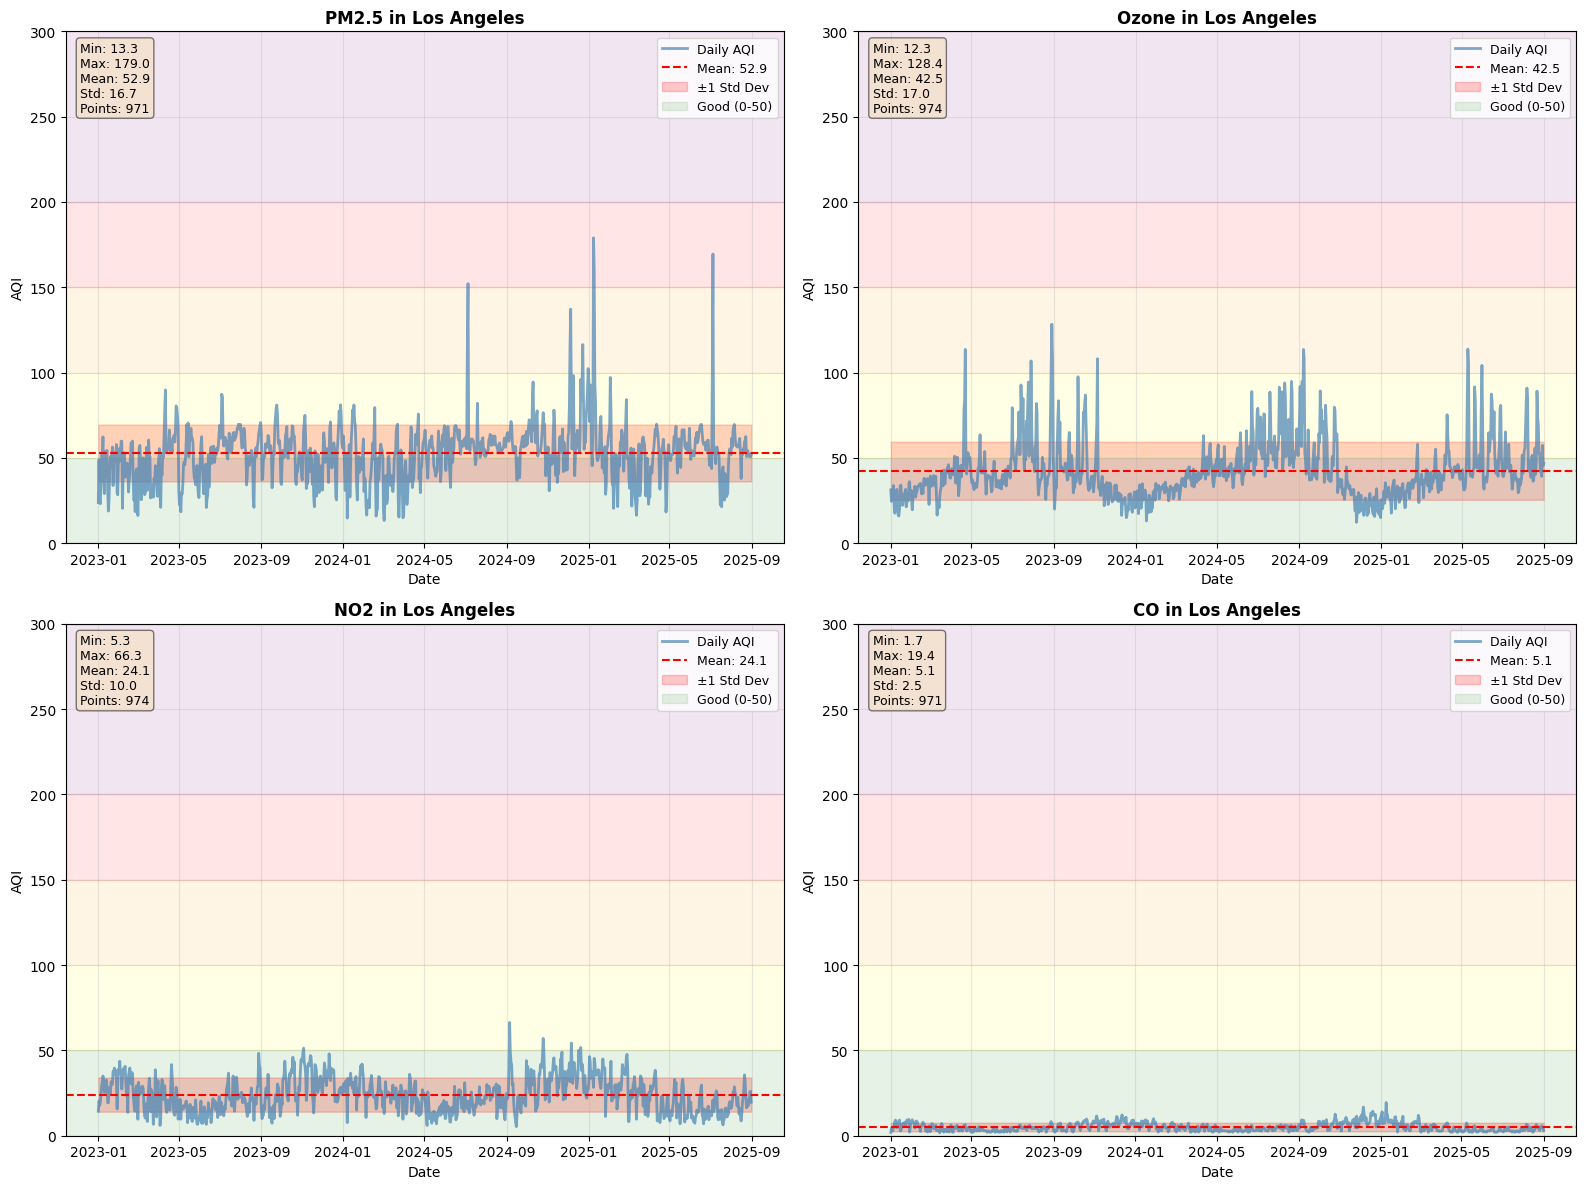


 Visualization complete for Los Angeles


In [142]:
# Create focused visualizations: ONE CITY, ONE POLLUTANT per graph
print("=" * 70)
print("DATA VISUALIZATION: FOCUSED ANALYSIS (EPA DATA)")
print("=" * 70)

# EPA data structure: [date, city, parameter, aqi, ...]
# Long format: pollutants are rows with a 'parameter' column
# Note: Pollutant names are now standardized (PM2.5, Ozone, NO2, CO, SO2, PM10)

# Quick reload EPA data if needed (in case file was updated)
print("\n[Quick Reload] Checking EPA data file...")
try:
    current_year = 2025
    EPA_CLEANED_FILE = f"epa_aqs_data_{current_year}_cleaned.csv"
    if os.path.exists(EPA_CLEANED_FILE):
        epa_cleaned = pd.read_csv(EPA_CLEANED_FILE)
        epa_cleaned['datetime'] = pd.to_datetime(epa_cleaned['datetime'])
        print(f" EPA data reloaded: {len(epa_cleaned):,} records")
    else:
        print(f"File not found: {EPA_CLEANED_FILE}")
except Exception as e:
    print(f"Error reloading EPA data: {e}")





if not epa_cleaned.empty:
    # Get available cities from EPA data
    available_cities = sorted(epa_cleaned['city'].unique())
    print(f"\nAvailable cities: {available_cities}")
    
    # Get available pollutants from EPA data (now with clean names)
    available_pollutants_in_data = sorted(epa_cleaned['parameter'].unique())
    print(f"Available pollutants in EPA data: {available_pollutants_in_data}")
    
    # Select focus city and pollutants to visualize
    focus_city = 'Los Angeles'  # Change this to explore different cities
    focus_pollutants = ['PM2.5', 'Ozone', 'NO2', 'CO']  # Pollutants to visualize
    
    if focus_city in available_cities:
        print(f"\n Creating visualizations for {focus_city}")
        
        # Create a 2x2 grid for 4 different pollutants
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for idx, pollutant_name in enumerate(focus_pollutants):
            if idx >= len(axes):
                break
            
            # Filter EPA data for this city and pollutant (no regex needed - names are clean!)
            city_data = epa_cleaned[epa_cleaned['city'] == focus_city].copy()
            
            if city_data.empty:
                axes[idx].text(0.5, 0.5, f'{pollutant_name}\nNo data for {focus_city}',
                             ha='center', va='center', fontsize=12, color='red')
                axes[idx].set_title(f'{pollutant_name} in {focus_city}')
                continue
            
            # Filter by pollutant parameter (simple equality check now)
            pollutant_data = city_data[city_data['parameter'] == pollutant_name].copy()
            
            if pollutant_data.empty:
                axes[idx].text(0.5, 0.5, f'{pollutant_name}\nNo valid data found',
                             ha='center', va='center', fontsize=12)
                axes[idx].set_title(f'{pollutant_name} in {focus_city}')
                continue
            
            # Sort by date
            pollutant_data['datetime'] = pd.to_datetime(pollutant_data['datetime'])
            pollutant_data = pollutant_data.sort_values('datetime')
            
            # Already aggregated to daily, just use directly
            daily_data = pollutant_data[['datetime', 'aqi']].dropna()
            
            if len(daily_data) > 0:
                ax = axes[idx]
                
                # Create time series plot
                ax.plot(daily_data['datetime'], daily_data['aqi'],
                       linewidth=2, color='steelblue', alpha=0.7, label='Daily AQI')
                
                # Add statistics
                mean_val = daily_data['aqi'].mean()
                std_val = daily_data['aqi'].std()
                min_val = daily_data['aqi'].min()
                max_val = daily_data['aqi'].max()
                
                # Add horizontal lines for mean and std
                ax.axhline(y=mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.1f}')
                ax.fill_between(daily_data['datetime'], 
                               mean_val - std_val, 
                               mean_val + std_val,
                               alpha=0.2, color='red', label=f'±1 Std Dev')
                
                # Add AQI category bands
                ax.axhspan(0, 50, alpha=0.1, color='green', label='Good (0-50)')
                ax.axhspan(50, 100, alpha=0.1, color='yellow')
                ax.axhspan(100, 150, alpha=0.1, color='orange')
                ax.axhspan(150, 200, alpha=0.1, color='red')
                ax.axhspan(200, 300, alpha=0.1, color='purple')
                ax.axhspan(300, 500, alpha=0.1, color='maroon')
                
                # Formatting
                ax.set_title(f'{pollutant_name} in {focus_city}', fontsize=12, fontweight='bold')
                ax.set_xlabel('Date', fontsize=10)
                ax.set_ylabel(f'AQI', fontsize=10)
                ax.grid(True, alpha=0.3)
                ax.legend(loc='best', fontsize=9)
                ax.set_ylim(0, max(300, max_val + 50))
                
                # Add statistics text box
                stats_text = f'Min: {min_val:.1f}\nMax: {max_val:.1f}\nMean: {mean_val:.1f}\nStd: {std_val:.1f}\nPoints: {len(daily_data)}'
                ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                       fontsize=9, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
                
            else:
                axes[idx].text(0.5, 0.5, f'{pollutant_name}\nInsufficient data for {focus_city}',
                             ha='center', va='center', fontsize=12)
                axes[idx].set_title(f'{pollutant_name} in {focus_city}')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n Visualization complete for {focus_city}")
    else:
        print(f"\n City '{focus_city}' not found in EPA data")
        print(f"   Available cities: {available_cities}")
else:
    print("No EPA data available for visualization")

DATA SOURCE COMPARISON: PM2.5 in Los Angeles

[1/2] KAGGLE HISTORIC DATA
----------------------------------------------------------------------
✓ Kaggle AQI data: 46 total measurements aggregated to 22 daily points
  Date range: 2023-11-28 to 2023-12-28
  Daily average AQI data points: 22

[2/2] EPA AQS DATA (RAW CONVERTED TO AQI)
----------------------------------------------------------------------
✓ EPA AQS AQI data: 4239 total measurements aggregated to 31 daily points
  Date range: 2025-08-02 to 2025-09-01
  Daily average AQI data points: 31
✓ EPA AQS AQI data: 4239 total measurements aggregated to 31 daily points
  Date range: 2025-08-02 to 2025-09-01
  Daily average AQI data points: 31


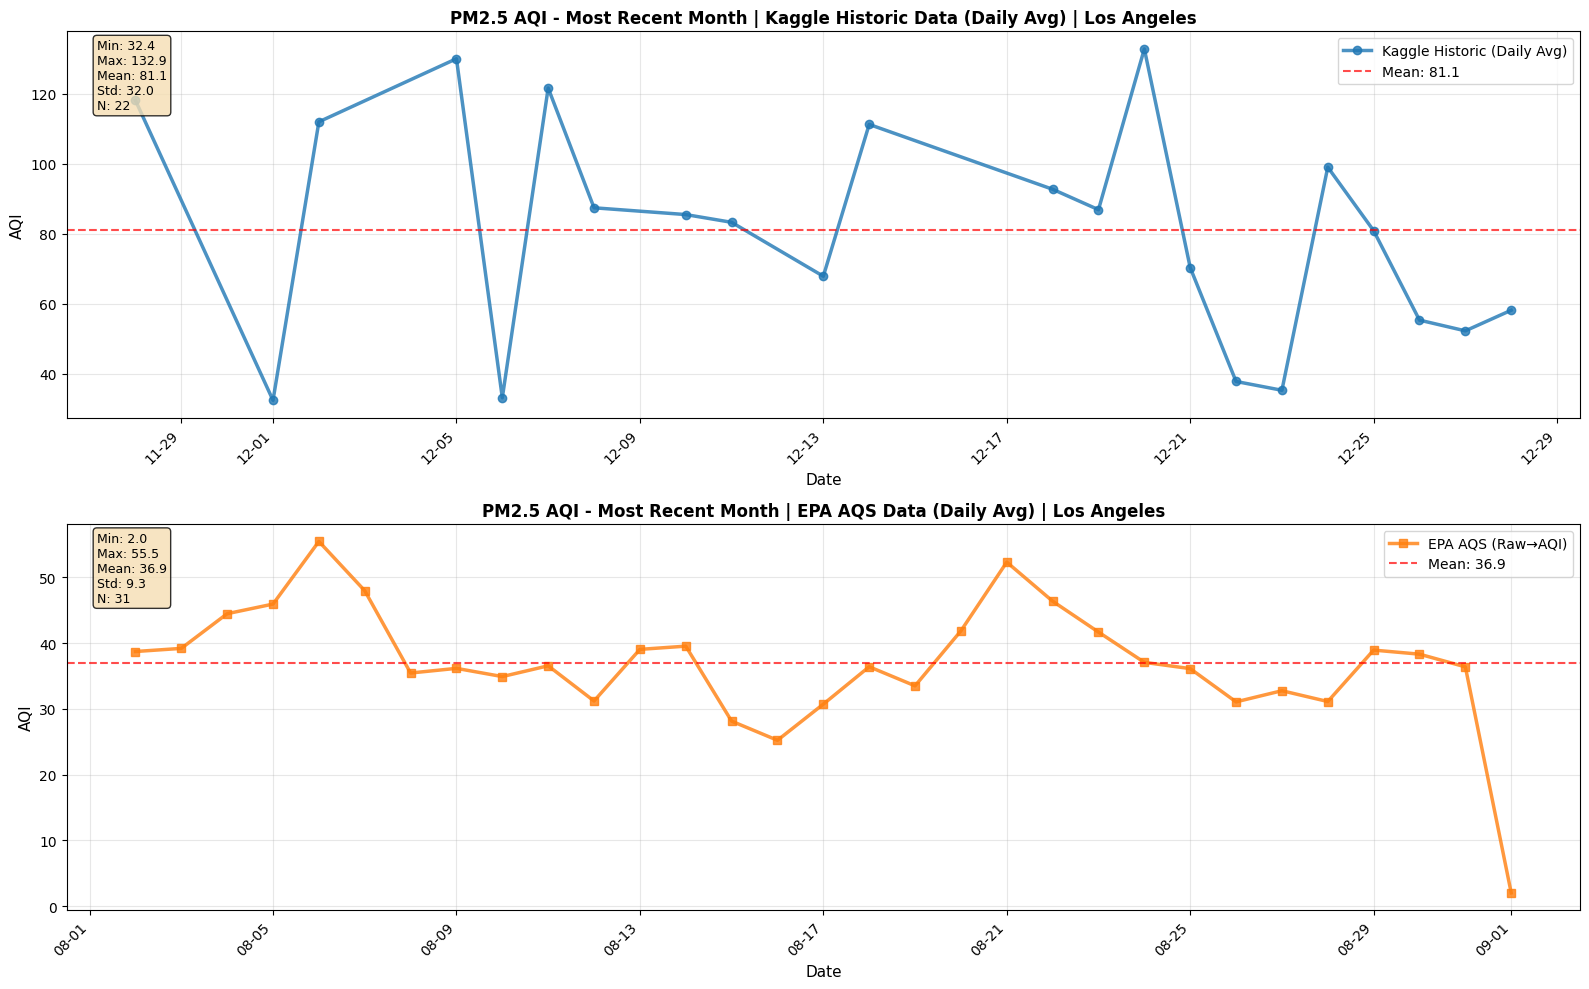

In [143]:
def visualize_aqi_comparison(city_focus, pollutant_focus):
    """
    Create a side-by-side comparison of AQI data from Kaggle and EPA AQS for a specific city and pollutant.
    
    Parameters:
    -----------
    city_focus : str
        The city name to visualize (e.g., 'Los Angeles')
    pollutant_focus : str
        The pollutant name to visualize (e.g., 'PM2.5', 'O3')
    """
    global aqs_data, historic_data
    
    print("=" * 70)
    print(f"DATA SOURCE COMPARISON: {pollutant_focus} in {city_focus}")
    print("=" * 70)

    # Create a figure with subplots for each source (2 graphs: Kaggle and EPA AQS)
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    axes_list = axes if isinstance(axes, np.ndarray) else [axes]

    import matplotlib.dates as mdates

    # ============================================================================
    # SOURCE 1: KAGGLE HISTORIC DATA (Wide format)
    # ============================================================================
    print("\n[1/2] KAGGLE HISTORIC DATA")
    print("-" * 70)
    kaggle_plotted = False
    if not historic_data.empty:
        try:
            # Find city column
            city_col_kaggle = None
            for col in ['City', 'city', 'CITY']:
                if col in historic_data.columns:
                    city_col_kaggle = col
                    break
            
            # Find date column
            date_col_kaggle = None
            for col in ['datetime', 'DateTime', 'date', 'Date', 'date_local']:
                if col in historic_data.columns:
                    date_col_kaggle = col
                    break
            
            if city_col_kaggle and date_col_kaggle and pollutant_focus in historic_data.columns:
                # Filter for focus city
                kaggle_city_data = historic_data[historic_data[city_col_kaggle] == city_focus].copy()
                
                # Get most recent month
                kaggle_city_data[date_col_kaggle] = pd.to_datetime(kaggle_city_data[date_col_kaggle])
                max_date = kaggle_city_data[date_col_kaggle].max()
                one_month_ago = max_date - timedelta(days=30)
                kaggle_recent = kaggle_city_data[
                    (kaggle_city_data[date_col_kaggle] >= one_month_ago) &
                    (kaggle_city_data[date_col_kaggle] <= max_date)
                ].copy()
                
                if not kaggle_recent.empty:
                    kaggle_recent = kaggle_recent.sort_values(date_col_kaggle)
                    
                    # Aggregate to one point per date (handle multiple measurements per day)
                    kaggle_recent['date_only'] = kaggle_recent[date_col_kaggle].dt.date
                    kaggle_daily = kaggle_recent.groupby('date_only')[pollutant_focus].mean().reset_index()
                    kaggle_daily.columns = ['date_only', 'aqi_value']
                    kaggle_daily['datetime'] = pd.to_datetime(kaggle_daily['date_only'])
                    
                    # Plot AQI values only
                    aqi_data = kaggle_daily['aqi_value'].dropna()
                    
                    if len(aqi_data) > 0:
                        ax = axes_list[0]
                        ax.plot(kaggle_daily['datetime'], aqi_data.values,
                               color='#1f77b4', marker='o', linestyle='-', linewidth=2.5,
                               markersize=6, alpha=0.8, label='Kaggle Historic (Daily Avg)')
                        
                        # Statistics
                        mean_val = aqi_data.mean()
                        std_val = aqi_data.std()
                        ax.axhline(y=mean_val, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Mean: {mean_val:.1f}')
                        
                        ax.set_title(f'{pollutant_focus} AQI - Most Recent Month | Kaggle Historic Data (Daily Avg) | {city_focus}',
                                    fontsize=12, fontweight='bold')
                        ax.set_xlabel('Date', fontsize=11)
                        ax.set_ylabel(f'AQI', fontsize=11)
                        ax.legend(loc='best', fontsize=10)
                        ax.grid(True, alpha=0.3)
                        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
                        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
                        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
                        
                        # Stats box
                        stats_text = f"Min: {aqi_data.min():.1f}\nMax: {aqi_data.max():.1f}\nMean: {mean_val:.1f}\nStd: {std_val:.1f}\nN: {len(aqi_data)}"
                        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
                        
                        kaggle_plotted = True
                        print(f"✓ Kaggle AQI data: {len(kaggle_recent)} total measurements aggregated to {len(kaggle_daily)} daily points")
                        print(f"  Date range: {kaggle_daily['date_only'].min()} to {kaggle_daily['date_only'].max()}")
                        print(f"  Daily average AQI data points: {len(aqi_data)}")
        except Exception as e:
            print(f"✗ Error processing Kaggle data: {e}")
            import traceback
            traceback.print_exc()

    if not kaggle_plotted:
        axes_list[0].text(0.5, 0.5, 'No Kaggle AQI data available', ha='center', va='center', fontsize=12, color='red')
        axes_list[0].set_title(f'{pollutant_focus} AQI - Kaggle Historic Data', fontsize=12)

    # ============================================================================
    # SOURCE 2: EPA AQS DATA (Convert raw to AQI)
    # ============================================================================
    print("\n[2/2] EPA AQS DATA (RAW CONVERTED TO AQI)")
    print("-" * 70)
    aqs_plotted = False
    
    try:
        if aqs_data is not None and not aqs_data.empty:
            # Find location/city column
            location_cols = ['location_name', 'city', 'City', 'location']
            city_col_aqs = None
            for col in location_cols:
                if col in aqs_data.columns:
                    city_col_aqs = col
                    break
            
            if city_col_aqs:
                # Filter for focus city
                aqs_city_data = aqs_data[aqs_data[city_col_aqs] == city_focus].copy()
                
                if not aqs_city_data.empty:
                    # Get most recent month
                    aqs_city_data['datetime'] = pd.to_datetime(aqs_city_data['datetime'])
                    max_date = aqs_city_data['datetime'].max()
                    one_month_ago = max_date - timedelta(days=30)
                    aqs_recent = aqs_city_data[
                        (aqs_city_data['datetime'] >= one_month_ago) &
                        (aqs_city_data['datetime'] <= max_date)
                    ].copy()
                    
                    if not aqs_recent.empty:
                        aqs_recent = aqs_recent.sort_values('datetime')
                        
                        # Get AQI values (should already be converted)
                        value_col_name = None
                        if 'aqi' in aqs_recent.columns and aqs_recent['aqi'].notna().sum() > 0:
                            value_col_name = 'aqi'
                        elif 'value' in aqs_recent.columns and aqs_recent['value'].notna().sum() > 0:
                            value_col_name = 'value'
                        elif 'arithmetic_mean' in aqs_recent.columns and aqs_recent['arithmetic_mean'].notna().sum() > 0:
                            value_col_name = 'arithmetic_mean'
                        
                        if value_col_name is not None:
                            # Extract just the date (without time) and aggregate to one point per date
                            aqs_recent['date_only'] = aqs_recent['datetime'].dt.date
                            aqs_daily = aqs_recent.groupby('date_only')[value_col_name].mean().reset_index()
                            aqs_daily.columns = ['date_only', 'aqi_value']
                            aqs_daily['datetime'] = pd.to_datetime(aqs_daily['date_only'])
                            
                            if len(aqs_daily) > 0:
                                ax = axes_list[1]
                                aqi_vals = aqs_daily['aqi_value']
                                daily_dates = aqs_daily['datetime']
                                
                                ax.plot(daily_dates, aqi_vals.values,
                                       color='#ff7f0e', marker='s', linewidth=2.5,
                                       markersize=6, alpha=0.8, label='EPA AQS (Raw→AQI)')
                                
                                # Statistics
                                mean_val = aqi_vals.mean()
                                std_val = aqi_vals.std()
                                ax.axhline(y=mean_val, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Mean: {mean_val:.1f}')
                                
                                ax.set_title(f'{pollutant_focus} AQI - Most Recent Month | EPA AQS Data (Daily Avg) | {city_focus}',
                                            fontsize=12, fontweight='bold')
                                ax.set_xlabel('Date', fontsize=11)
                                ax.set_ylabel(f'AQI', fontsize=11)
                                ax.legend(loc='best', fontsize=10)
                                ax.grid(True, alpha=0.3)
                                ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
                                ax.xaxis.set_major_locator(mdates.AutoDateLocator())
                                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
                                
                                # Stats box
                                stats_text = f"Min: {aqi_vals.min():.1f}\nMax: {aqi_vals.max():.1f}\nMean: {mean_val:.1f}\nStd: {std_val:.1f}\nN: {len(aqi_vals)}"
                                ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, verticalalignment='top',
                                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
                                
                                aqs_plotted = True
                                print(f"✓ EPA AQS AQI data: {len(aqs_recent)} total measurements aggregated to {len(aqs_daily)} daily points")
                                print(f"  Date range: {aqs_daily['date_only'].min()} to {aqs_daily['date_only'].max()}")
                                print(f"  Daily average AQI data points: {len(aqs_daily)}")
                        else:
                            print(f"✗ No valid AQI column found in EPA data")
                    else:
                        print(f"✗ No EPA data found for {city_focus} in the recent month")
                else:
                    print(f"✗ No EPA data found for city: {city_focus}")
                    print(f"   Available cities in EPA data: {aqs_data[city_col_aqs].unique()[:10].tolist()}")
            else:
                print(f"✗ Could not find city column in EPA data")
                print(f"   Available columns: {aqs_data.columns.tolist()}")
        else:
            print(f"✗ EPA data (aqs_data) is not available or empty")
    except Exception as e:
        print(f"✗ Error processing EPA AQS data: {e}")
        import traceback
        traceback.print_exc()

    if not aqs_plotted:
        axes_list[1].text(0.5, 0.5, 'No EPA AQS AQI data available', ha='center', va='center', fontsize=12, color='red')
        axes_list[1].set_title(f'{pollutant_focus} AQI - EPA AQS Data', fontsize=12)

    plt.tight_layout()
    plt.show()



# Call the function with desired city and pollutant
visualize_aqi_comparison('Los Angeles', 'PM2.5')

## 7. Autocorrelation and Partial Autocorrelation

TIME SERIES ANALYSIS: AUTOCORRELATION & PARTIAL AUTOCORRELATION

Loading EPA cleaned data from: C:\Users\Matt_Local\OneDrive - Northeastern University\Academics\Data Mining\Project\air_quality\data\epa_aqs_data_2025_cleaned.csv
✓ Loaded 15506 records from EPA cleaned data
  Cities available: ['Chicago' 'Northbrook' 'Pasadena' 'Pico Rivera' 'Pomona' 'Reseda'
 'Santa Clarita' 'Schiller Park' 'Signal Hill' 'West Los Angeles'
 'New York' 'Cicero' 'Compton' 'Glendora' 'Lancaster' 'Lansing'
 'Los Angeles' 'McCook' 'Long Beach' 'Lemont' 'Alsip' 'Des Plaines'
 'Evanston']
  Pollutants available: ['Sulfur dioxide' 'Ozone' 'PM10 Total 0-10um STP' 'Carbon monoxide'
 'Nitrogen dioxide (NO2)' 'PM2.5 - Local Conditions']

ANALYZING LOS ANGELES DATA

ANALYZING: PM2.5 in Los Angeles
✓ Time series prepared: 241 daily observations
  Date range: 2025-01-01 to 2025-08-31
  Mean: 53.96 | Std: 19.11

 ACF & PACF INTERPRETATION:
----------------------------------------------------------------------
  Confide

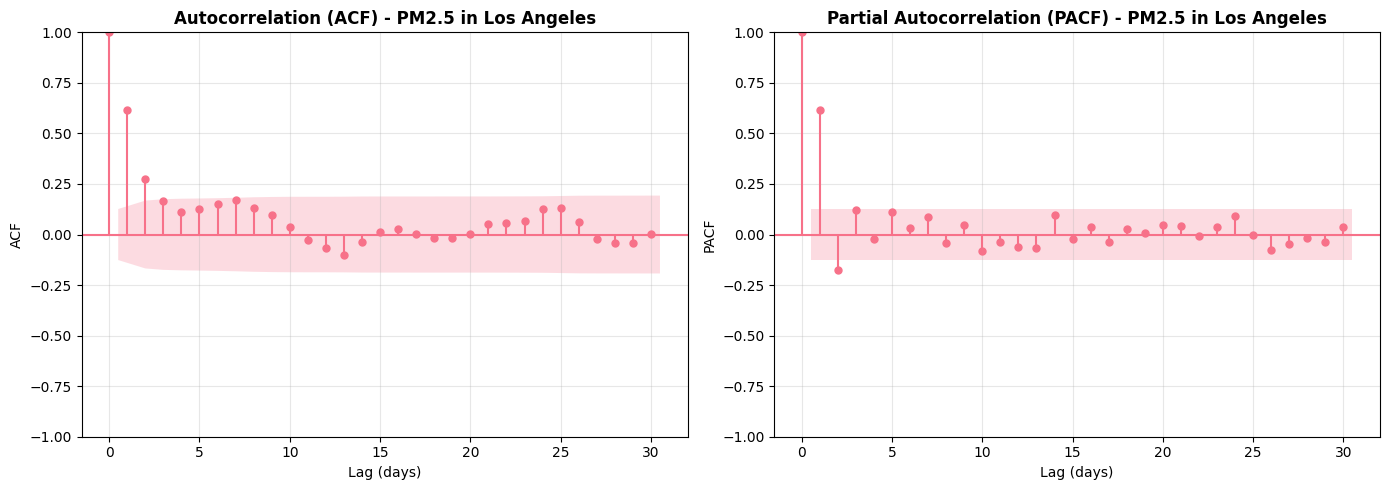



ANALYZING: Ozone in Los Angeles
✓ Time series prepared: 243 daily observations
  Date range: 2025-01-01 to 2025-08-31
  Mean: 43.64 | Std: 15.75

 ACF & PACF INTERPRETATION:
----------------------------------------------------------------------
  Confidence Interval: ±0.126

  Significant ACF lags (first 5): [1, 2, 3, 4, 5]
  Significant PACF lags (first 5): [1, 2, 9, 10]
  → Strong autocorrelation suggests Ozone is PERSISTENT
    (Today's value strongly predicts tomorrow's value)


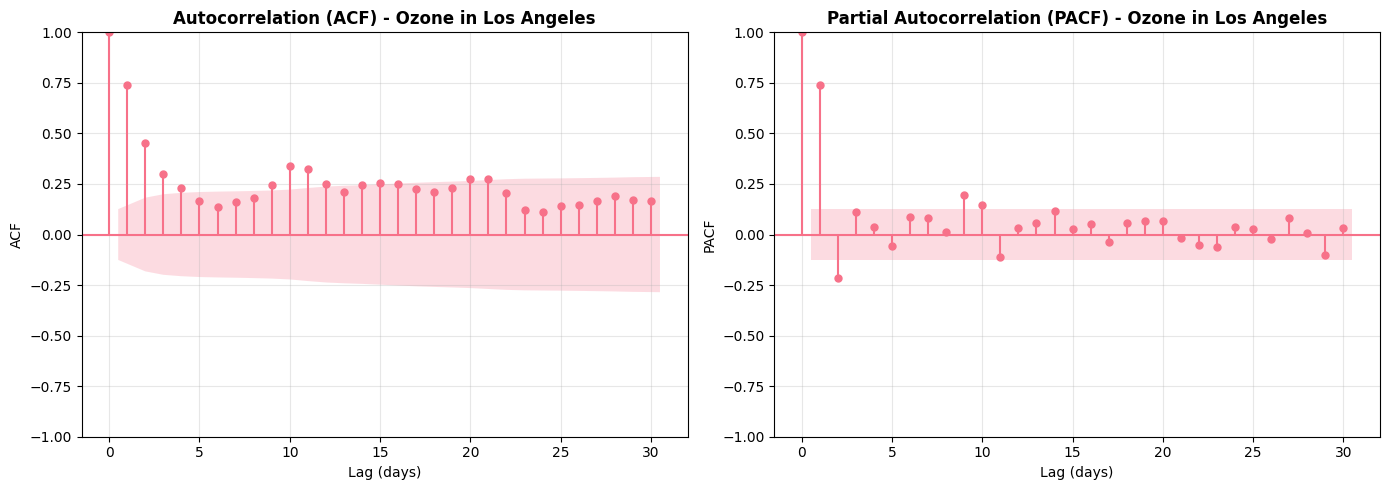



ANALYZING: NO2 in Los Angeles
✓ Time series prepared: 243 daily observations
  Date range: 2025-01-01 to 2025-08-31
  Mean: 22.13 | Std: 9.94

 ACF & PACF INTERPRETATION:
----------------------------------------------------------------------
  Confidence Interval: ±0.126

  Significant ACF lags (first 5): [1, 2, 3, 4, 5]
  Significant PACF lags (first 5): [1, 9]
  → Strong autocorrelation suggests NO2 is PERSISTENT
    (Today's value strongly predicts tomorrow's value)


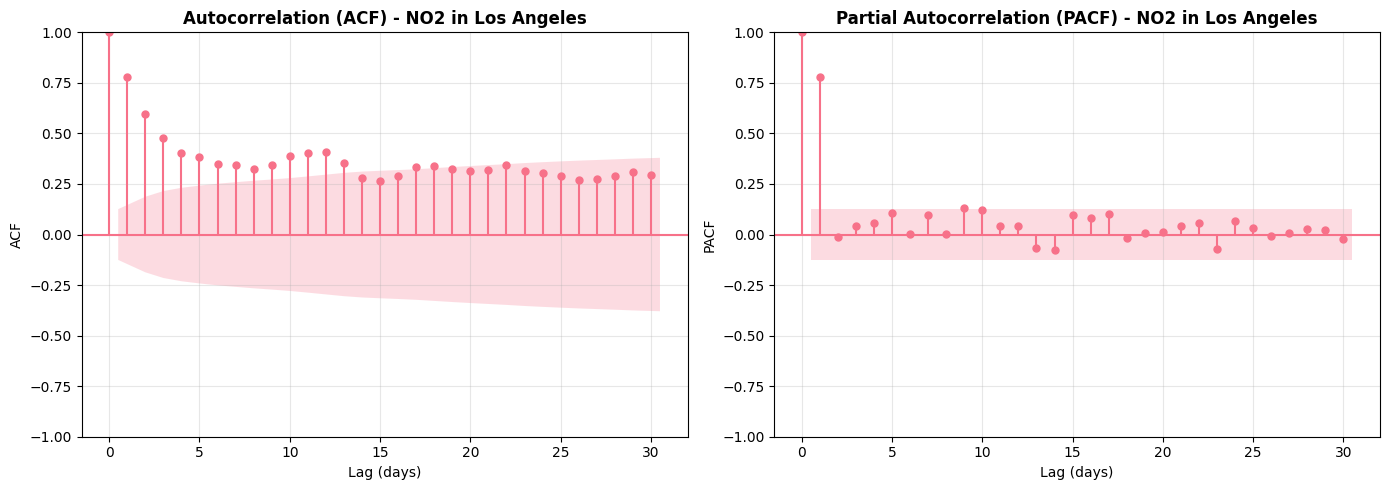

In [144]:
# ============================================================================
# AUTOCORRELATION & PARTIAL AUTOCORRELATION ANALYSIS
# ============================================================================
print("=" * 70)
print("TIME SERIES ANALYSIS: AUTOCORRELATION & PARTIAL AUTOCORRELATION")
print("=" * 70)

# Install statsmodels if not already installed
try:
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.stattools import acf, pacf
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.stattools import acf, pacf

def analyze_autocorrelation(epa_data, city_name, pollutant_name, nlags=30):
    """
    Compute and visualize autocorrelation (ACF) and partial autocorrelation (PACF)
    for a specific pollutant in a city using EPA cleaned data.
    
    Parameters:
    -----------
    epa_data : pd.DataFrame
        EPA cleaned data with columns: datetime, city, parameter, aqi
    city_name : str
        City to analyze
    pollutant_name : str
        Pollutant to analyze (e.g., 'PM2.5', 'Ozone', 'NO2')
    nlags : int
        Number of lags to display (default 30)
    
    Returns:
    --------
    dict : Dictionary containing ACF and PACF values
    """
    print(f"\n{'='*70}")
    print(f"ANALYZING: {pollutant_name} in {city_name}")
    print(f"{'='*70}")
    
    results = {}
    
    try:
        # Filter data for the city
        city_data = epa_data[epa_data['city'] == city_name].copy()
        
        if city_data.empty:
            print(f"✗ No data found for city: {city_name}")
            print(f"  Available cities: {epa_data['city'].unique()}")
            return results
        
        # Filter for the specific pollutant
        # EPA data has 'parameter' column with full names
        pollutant_filter_map = {
            'PM2.5': ['PM2.5', 'PM25', 'PM2.5 - Local Conditions'],
            'Ozone': ['Ozone', 'O3'],
            'NO2': ['NO2', 'Nitrogen Dioxide'],
            'SO2': ['SO2', 'Sulfur Dioxide'],
            'CO': ['CO', 'Carbon Monoxide'],
        }
        
        if pollutant_name not in pollutant_filter_map:
            print(f"✗ Pollutant '{pollutant_name}' not recognized")
            print(f"  Available: {list(pollutant_filter_map.keys())}")
            return results
        
        # Filter to the specific pollutant
        city_data = city_data[city_data['parameter'].str.contains('|'.join(pollutant_filter_map[pollutant_name]), case=False, na=False)]
        
        if city_data.empty:
            print(f"✗ Pollutant '{pollutant_name}' not found for {city_name}")
            print(f"  Available pollutants: {epa_data[epa_data['city'] == city_name]['parameter'].unique()}")
            return results
        
        # Sort by date and prepare time series
        city_data['datetime'] = pd.to_datetime(city_data['datetime'])
        city_data = city_data.sort_values('datetime')
        
        # Aggregate to daily averages (EPA might have multiple values per day per pollutant)
        city_data['date_only'] = city_data['datetime'].dt.date
        daily_data = city_data.groupby('date_only')['aqi'].mean()
        
        # Remove NaN values
        ts_data = daily_data.dropna()
        
        if len(ts_data) < nlags + 1:
            print(f"Not enough data points ({len(ts_data)}) for {nlags} lags. Using {len(ts_data)//2} lags instead.")
            nlags = len(ts_data) // 2
        
        print(f"✓ Time series prepared: {len(ts_data)} daily observations")
        print(f"  Date range: {daily_data.index.min()} to {daily_data.index.max()}")
        print(f"  Mean: {ts_data.mean():.2f} | Std: {ts_data.std():.2f}")
        
        # Compute ACF and PACF
        acf_values = acf(ts_data, nlags=nlags, fft=True)
        pacf_values = pacf(ts_data, nlags=nlags, method='ywmle')
        
        results = {
            'ts_data': ts_data,
            'acf_values': acf_values,
            'pacf_values': pacf_values,
            'nlags': nlags,
            'city': city_name,
            'pollutant': pollutant_name
        }
        
        # Print interpretation
        print(f"\n ACF & PACF INTERPRETATION:")
        print(f"-" * 70)
        
        # Find significant lags (beyond confidence interval)
        confidence_interval = 1.96 / np.sqrt(len(ts_data))
        print(f"  Confidence Interval: ±{confidence_interval:.3f}")
        
        significant_acf = np.where(np.abs(acf_values[1:]) > confidence_interval)[0] + 1
        significant_pacf = np.where(np.abs(pacf_values[1:]) > confidence_interval)[0] + 1
        
        print(f"\n  Significant ACF lags (first 5): {significant_acf[:5].tolist()}")
        print(f"  Significant PACF lags (first 5): {significant_pacf[:5].tolist()}")
        
        if len(significant_acf) > 0:
            print(f"  → Strong autocorrelation suggests {pollutant_name} is PERSISTENT")
            print(f"    (Today's value strongly predicts tomorrow's value)")
        else:
            print(f"  → Weak autocorrelation suggests {pollutant_name} is RANDOM")
            print(f"    (Today's value has little predictive power for tomorrow)")
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # ACF plot
        plot_acf(ts_data, lags=nlags, ax=axes[0], alpha=0.05)
        axes[0].set_title(f'Autocorrelation (ACF) - {pollutant_name} in {city_name}', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Lag (days)')
        axes[0].set_ylabel('ACF')
        axes[0].grid(True, alpha=0.3)
        
        # PACF plot
        plot_pacf(ts_data, lags=nlags, ax=axes[1], alpha=0.05, method='ywmle')
        axes[1].set_title(f'Partial Autocorrelation (PACF) - {pollutant_name} in {city_name}', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Lag (days)')
        axes[1].set_ylabel('PACF')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"✗ Error in autocorrelation analysis: {e}")
        import traceback
        traceback.print_exc()
    
    return results


# Load EPA cleaned data
EPA_CLEANED_FILE = r"C:\Users\Matt_Local\OneDrive - Northeastern University\Academics\Data Mining\Project\air_quality\data\epa_aqs_data_2025_cleaned.csv"
print(f"\nLoading EPA cleaned data from: {EPA_CLEANED_FILE}")
epa_cleaned = pd.read_csv(EPA_CLEANED_FILE)
epa_cleaned['datetime'] = pd.to_datetime(epa_cleaned['datetime'])
print(f"✓ Loaded {len(epa_cleaned)} records from EPA cleaned data")
print(f"  Cities available: {epa_cleaned['city'].unique()}")
print(f"  Pollutants available: {epa_cleaned['parameter'].unique()}\n")

# Run analysis for primary pollutants in Los Angeles
print("ANALYZING LOS ANGELES DATA")
print("="*70)

for pollutant in ['PM2.5', 'Ozone', 'NO2']:
    results = analyze_autocorrelation(epa_cleaned, 'Los Angeles', pollutant, nlags=30)
    print()

#### ACF and PACF anaylsis

From this simple anaylsis we can see that PM2.5 and NO2 appear to have a statistically significant seasonal correlation at around 22-23 days. While O3 does not. We will need to perform this analysis for each city to determine what the SARIMA parameters should be.

In [145]:
# ============================================================================
# DETERMINE SARIMA PARAMETERS FROM ACF/PACF
# ============================================================================

def determine_sarima_parameters(ts_data, nlags=30):
    """
    Determine SARIMA(p,d,q)(P,D,Q,s) parameters from ACF/PACF analysis.
    Only outputs the recommended parameters to try.
    """
    from statsmodels.tsa.stattools import adfuller
    
    ts_data = ts_data.dropna()
    
    if len(ts_data) < nlags + 1:
        nlags = len(ts_data) // 2
    
    # Compute ACF and PACF
    acf_values = acf(ts_data, nlags=nlags, fft=True)
    pacf_values = pacf(ts_data, nlags=nlags, method='ywmle')
    
    # Calculate confidence interval
    confidence_interval = 1.96 / np.sqrt(len(ts_data))
    
    # Find significant lags
    significant_acf = np.where(np.abs(acf_values[1:]) > confidence_interval)[0] + 1
    significant_pacf = np.where(np.abs(pacf_values[1:]) > confidence_interval)[0] + 1
    
    # =====================================================================
    # Determine d (differencing)
    # =====================================================================
    adf_result = adfuller(ts_data, autolag='AIC')
    d = 0 if adf_result[1] < 0.05 else 1
    
    # =====================================================================
    # Determine p from PACF (first significant lag)
    # =====================================================================
    p = 1
    for lag in range(1, min(6, len(significant_pacf) + 1)):
        if lag in significant_pacf:
            p = lag
        else:
            break
    
    # =====================================================================
    # Determine q from ACF (first significant lag)
    # =====================================================================
    q = 1
    for lag in range(1, min(6, len(significant_acf) + 1)):
        if lag in significant_acf:
            q = lag
        else:
            break
    
    # =====================================================================
    # Detect seasonal parameters - CHECK FOR EXACT LAGS (22, 23 DAY CYCLES)
    # =====================================================================
    s_candidates = {}
    
    # Check for seasonal spikes at specific lags: 7, 22, 23, 30
    for season_lag in range(1,31):
        if season_lag > nlags:
            continue
        
        # Check if this exact lag has a significant spike
        if season_lag in significant_acf or season_lag in significant_pacf:
            s_candidates[season_lag] = 1
        
        # Also check for multiples of this lag (e.g., 46, 69 for 23-day cycle)
        for multiple in range(2, 4):
            multiple_lag = season_lag * multiple
            if multiple_lag > nlags:
                break
            if multiple_lag in significant_acf or multiple_lag in significant_pacf:
                s_candidates[season_lag] = s_candidates.get(season_lag, 0) + 1
    
    # Use strongest seasonal period
    if s_candidates:
        s = max(s_candidates, key=s_candidates.get)
        P, D, Q = 1, 0, 1
    else:
        s = 1
        P, D, Q = 0, 0, 0
    
    # =====================================================================
    # Return recommended models
    # =====================================================================
    print("\n" + "="*70)
    print("RECOMMENDED SARIMA MODELS TO TEST")
    print("="*70)
    
    models = [
        ((p, d, q), (0, 0, 0, 1)),
        ((p, d, q), (P, D, Q, s)),
        ((p+1, d, q), (P, D, Q, s)),
        ((p, d, q+1), (P, D, Q, s)),
        ((p+1, d, q+1), (P, D, Q, s)),
    ]
    
    print(f"\nTop candidates (in order to try):\n")
    for i, (order, seasonal_order) in enumerate(models, 1):
        print(f"{i}. SARIMA{order}{seasonal_order}")
    
    print(f"\nSeasonal period detected: {s} days")
    print(f"Non-seasonal: p={p}, d={d}, q={q}")
    if s != 1:
        print(f"Seasonal: P={P}, D={D}, Q={Q}, s={s}")
    
    print("="*70 + "\n")
    
    return models


# Get Los Angeles PM2.5 data from EPA cleaned data and determine parameters
la_pm25_data = epa_cleaned[(epa_cleaned['city'] == 'Los Angeles') & 
                            (epa_cleaned['parameter'].str.contains('PM2.5|PM25', case=False, na=False))].copy()

if not la_pm25_data.empty:
    la_pm25_data['datetime'] = pd.to_datetime(la_pm25_data['datetime'])
    la_pm25_data = la_pm25_data.sort_values('datetime')
    la_pm25_data['date_only'] = la_pm25_data['datetime'].dt.date
    la_pm25_daily = la_pm25_data.groupby('date_only')['aqi'].mean()
    
    print("\nLOS ANGELES PM2.5 - SARIMA PARAMETER RECOMMENDATIONS (EPA Data)")
    model_configs = determine_sarima_parameters(la_pm25_daily, nlags=30)
else:
    print("\n✗ PM2.5 data not found for Los Angeles in EPA cleaned data")


LOS ANGELES PM2.5 - SARIMA PARAMETER RECOMMENDATIONS (EPA Data)

RECOMMENDED SARIMA MODELS TO TEST

Top candidates (in order to try):

1. SARIMA(2, 0, 3)(0, 0, 0, 1)
2. SARIMA(2, 0, 3)(1, 0, 1, 1)
3. SARIMA(3, 0, 3)(1, 0, 1, 1)
4. SARIMA(2, 0, 4)(1, 0, 1, 1)
5. SARIMA(3, 0, 4)(1, 0, 1, 1)

Seasonal period detected: 1 days
Non-seasonal: p=2, d=0, q=3

